In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow import keras
from tensorflow.keras import layers
from keras.optimizers import Adam
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin

In [3]:
df = pd.read_csv('/kaggle/input/spotify-dataset/dataset.csv')
sns.set(style="whitegrid")

In [4]:
df.head()

Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       210826     False   
3  Can't Help Falling In Love          71       201933     False   
4                     Hold On          82       198853     False   

   danceability  energy  ...  loudness  mode  speechiness  acousticness  \
0         0.676  0.4610  ...    -6.746     0       0.1430        0.0322   
1         0.420  0.1660  ...   -17.235     1       0.0763        0.9240   
2         0.438  0.3590  ...    -9.734     1       0.0557        0.2100   
3         0.266  0.0596  ...   -18.515     1       0.0363        0.9050   
4         0.618  0.4430  ...    -9.681     1       0.0526        0.4690   

   instrumentalness  liveness  valence    tempo  time_signature  track_genre  
0          0.000001    0.3580    0.715   87.917               4     acoustic  
1          0.000006    0.1010    0.267   77.489               4     acoustic  
2          0.000000    0.1170    0.120   76.332               4     acoustic  
3          0.000071    0.1320    0.143  181.740               3     acoustic  
4          0.000000    0.0829    0.167  119.949               4     acoustic  

[5 rows x 21 columns]

In [5]:
df.isnull().sum()

Unnamed: 0          0
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

In [6]:
df.dropna(inplace=True)

In [7]:
df.drop(columns=['Unnamed: 0', 'album_name', 'track_name', 'track_id'], inplace=True)

In [8]:
df.isnull().sum()

artists             0
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


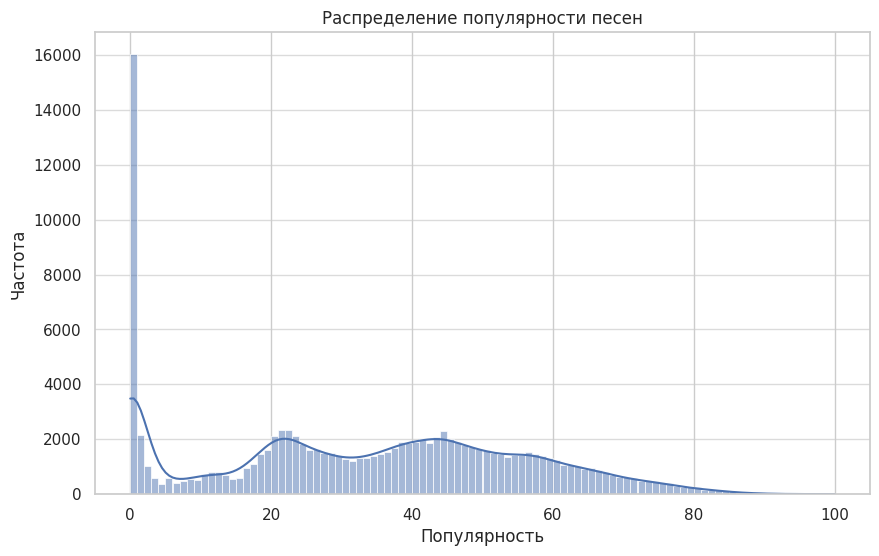

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(df['popularity'], bins=100, kde=True)
plt.title('Распределение популярности песен')
plt.xlabel('Популярность')
plt.ylabel('Частота')
plt.grid(axis='y', alpha=0.7)
plt.show()

На графике видно, что песни по популярности распределенные очень не равномерно, так песен с популярностью выше 80 практически нет, а песен с 0 и около нулевой популярностью неверноятно много, что будет препятствовать построению хорошей модели

In [10]:
# Проверка уникальных значений и количества нулей
unique_popularity = df['popularity'].unique()
zero_popularity_count = (df['popularity'] == 0).sum()
total_songs = len(df)
zero_popularity_percentage = (zero_popularity_count / total_songs) * 100

print(f"Уникальные значения популярности: {unique_popularity}")
print(f"Количество песен с популярностью 0: {zero_popularity_count}")
print(f"Процент песен с популярностью 0: {zero_popularity_percentage:.2f}%")

Уникальные значения популярности: [ 73  55  57  71  82  58  74  80  56  69  52  62  54  68  67  75  63  70
   0   1  46  61  60  51  66  64  65  44  45  50  59  49  53  47  43  42
  20  22  35  19  24  18  23  40  38  41  30  37  39  48  36  34  26  32
  33  21  31  28  29  27  25  16   3  12   7  10   9  11  17   8  15  87
  83  86  93  76  78   4   2   5  85  81  84  72  79  77   6  13  14  89
  96 100  98  88  92  90  91  99  97  95  94]
Количество песен с популярностью 0: 16019
Процент песен с популярностью 0: 14.05%


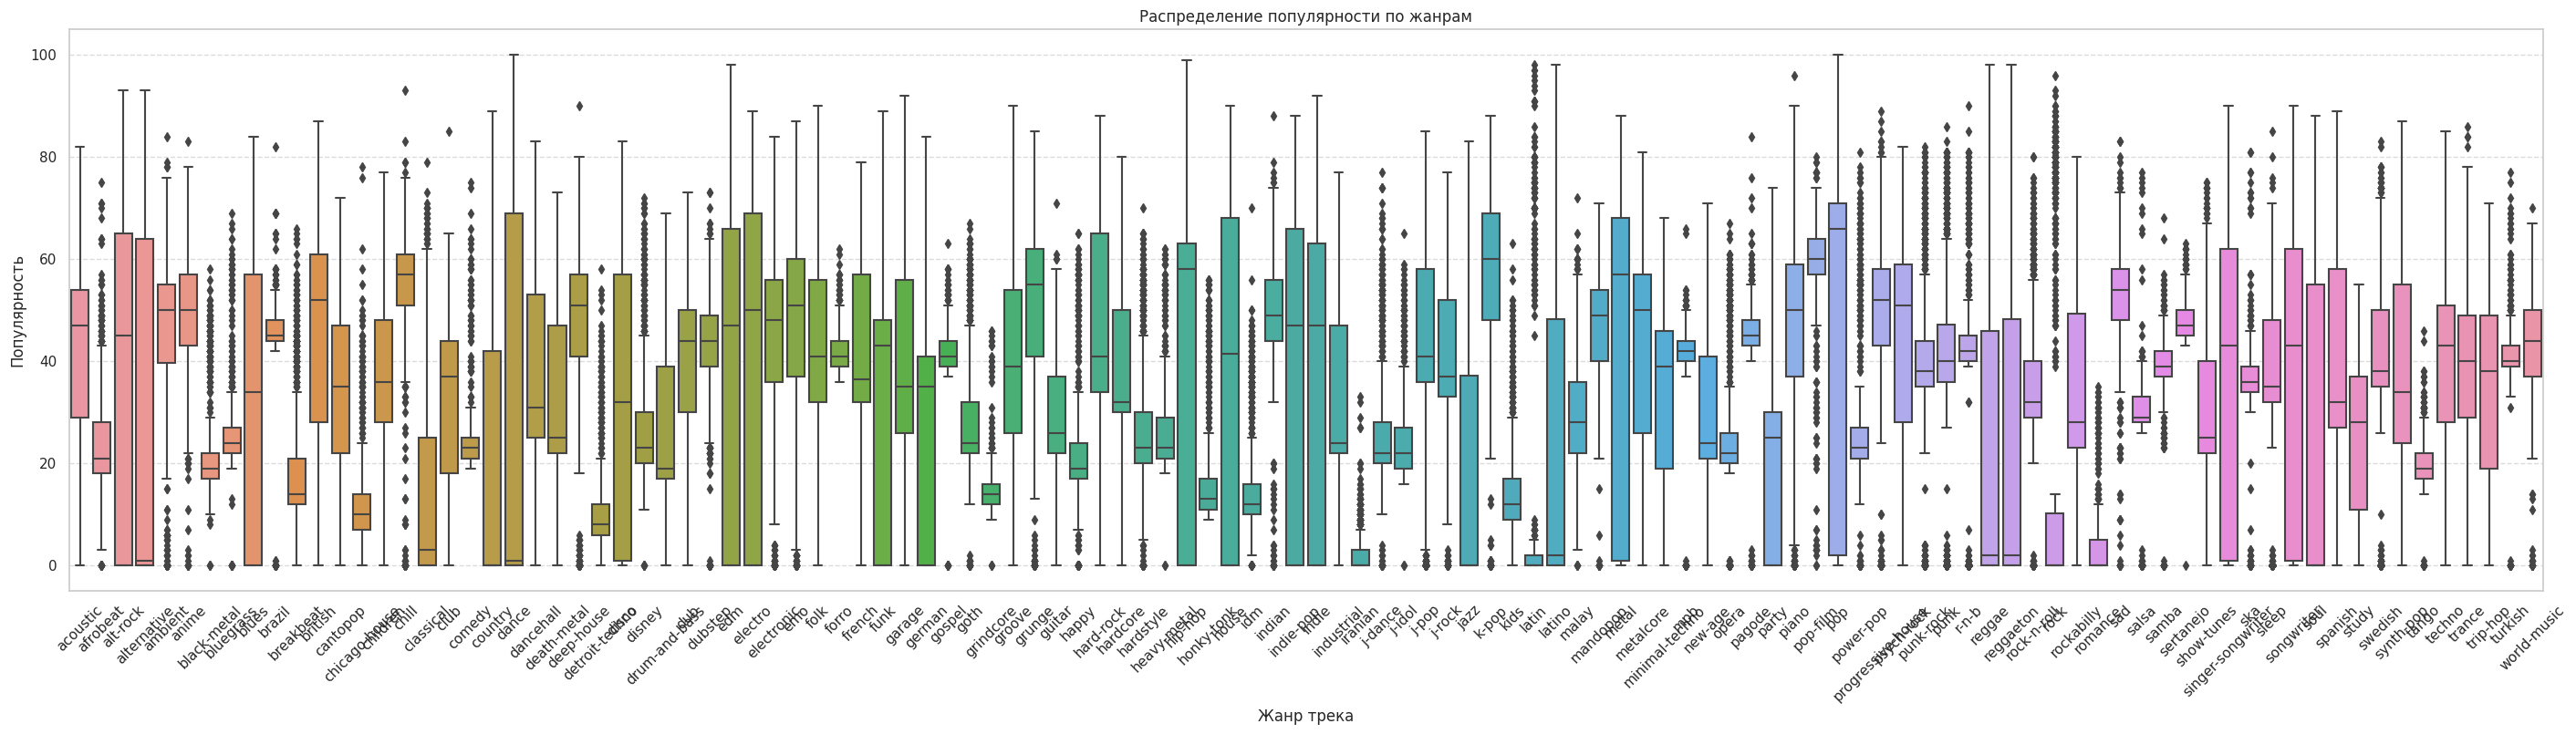

In [11]:
# Случайная выборка жанров для наглядности
sample_genres = df['track_genre']
sample_data = df[df['track_genre'].isin(sample_genres)]

plt.figure(figsize=(35, 8))
sns.boxplot(data=sample_data, x='track_genre', y='popularity')
plt.title('Распределение популярности по жанрам')
plt.xticks(rotation=45)
plt.xlabel('Жанр трека')
plt.ylabel('Популярность')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


На этом графике показано распределение популярности по жанрам. Из этого рафика можно увидеть, что почти все жанры имеют распределение от 0 до 60+-5, но также есть маленькие жанры (которые имеют малое количество песен), которые распологаются в самом низу популярности и наверху популярности.

Можно разделить эти жанры по кол-ву песен, либо разделить на популярные и не популярные маленькие жанры, а остальные большие жанры выделить отдельно т.к они имеют большой разброс по популярности.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


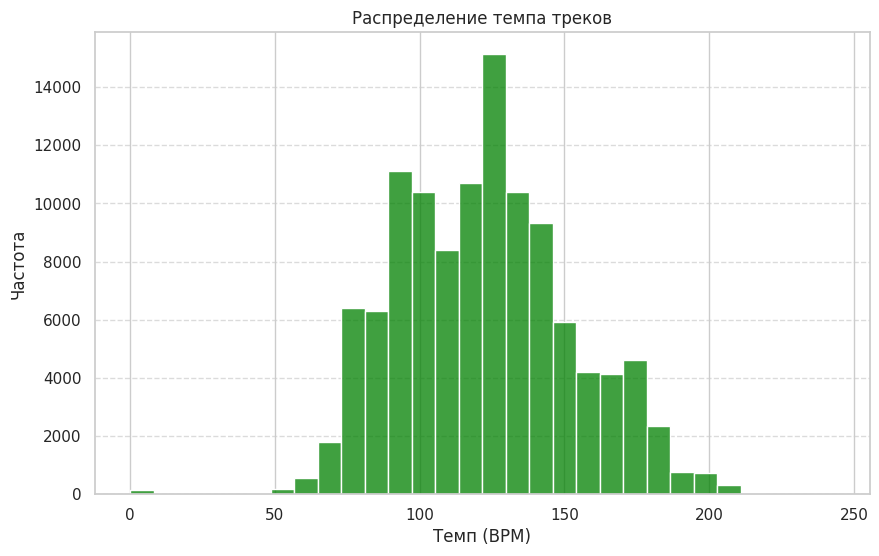

In [12]:
# Построение гистограммы для распределения темпа
plt.figure(figsize=(10, 6))
sns.histplot(df['tempo'], bins=30, color='green')
plt.title('Распределение темпа треков')
plt.xlabel('Темп (BPM)')
plt.ylabel('Частота')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Песни имеет неравномерное распределение по темпу, так больше всего пемен темпом от 100, до 150.

Можно также выделить 3 категории темпа - медленный T < 100, средний 100 <= T < 150, быст T >= 150
Можно попробовать добавить распределние по популярности от отношения длительности песни к громкости (долго громкую музыку может быть трудно слушать)

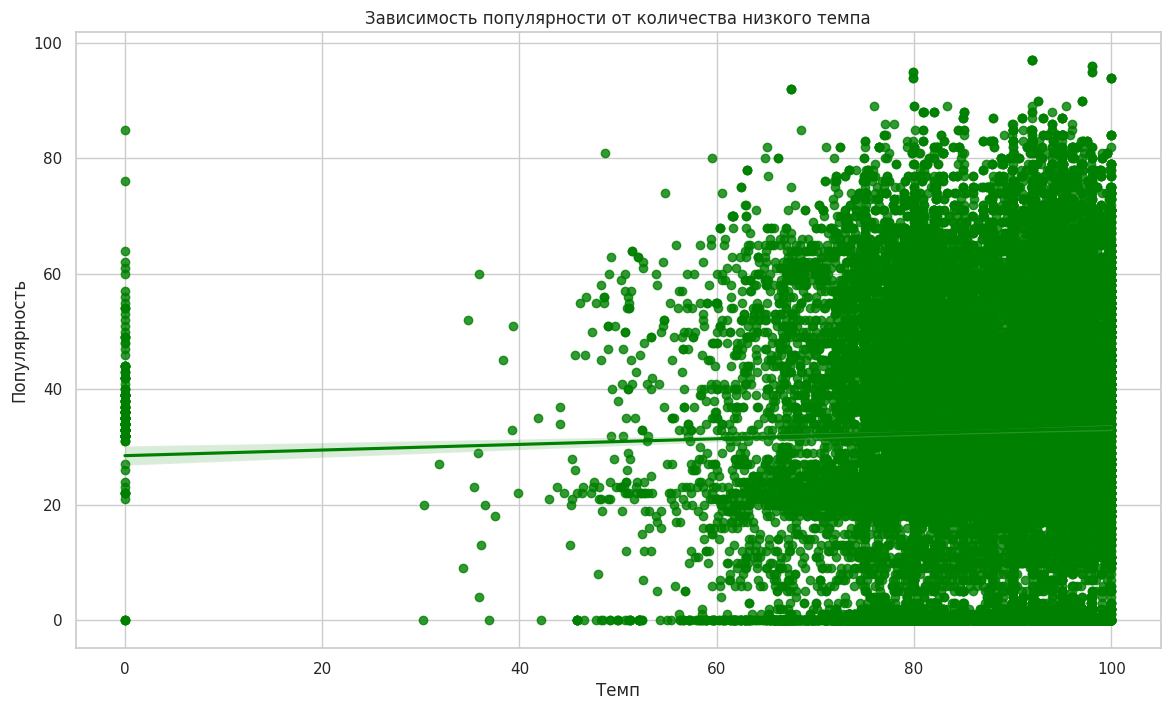

In [13]:
plt.figure(figsize=(14, 8))
sns.regplot(y=df[df['tempo'] < 100]['popularity'], x=df[df['tempo'] < 100]['tempo'], color='green')
plt.title('Зависимость популярности от количества низкого темпа')
plt.ylabel('Популярность')
plt.xlabel('Темп')

plt.show()

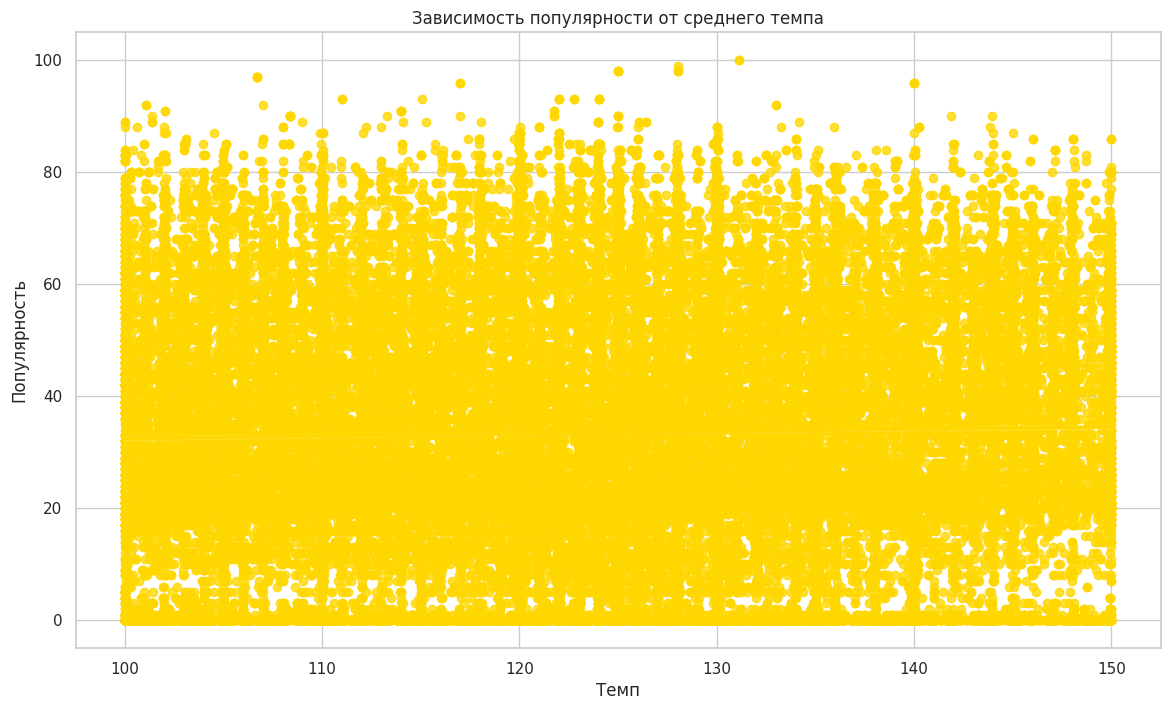

In [14]:
plt.figure(figsize=(14, 8))
sns.regplot(y=df[(df['tempo'] >= 100) & (df['tempo'] < 150)]['popularity'], x=df[(df['tempo'] >= 100) & (df['tempo'] < 150)]['tempo'], color='gold')
plt.title('Зависимость популярности от среднего темпа')
plt.ylabel('Популярность')
plt.xlabel('Темп')

plt.show()

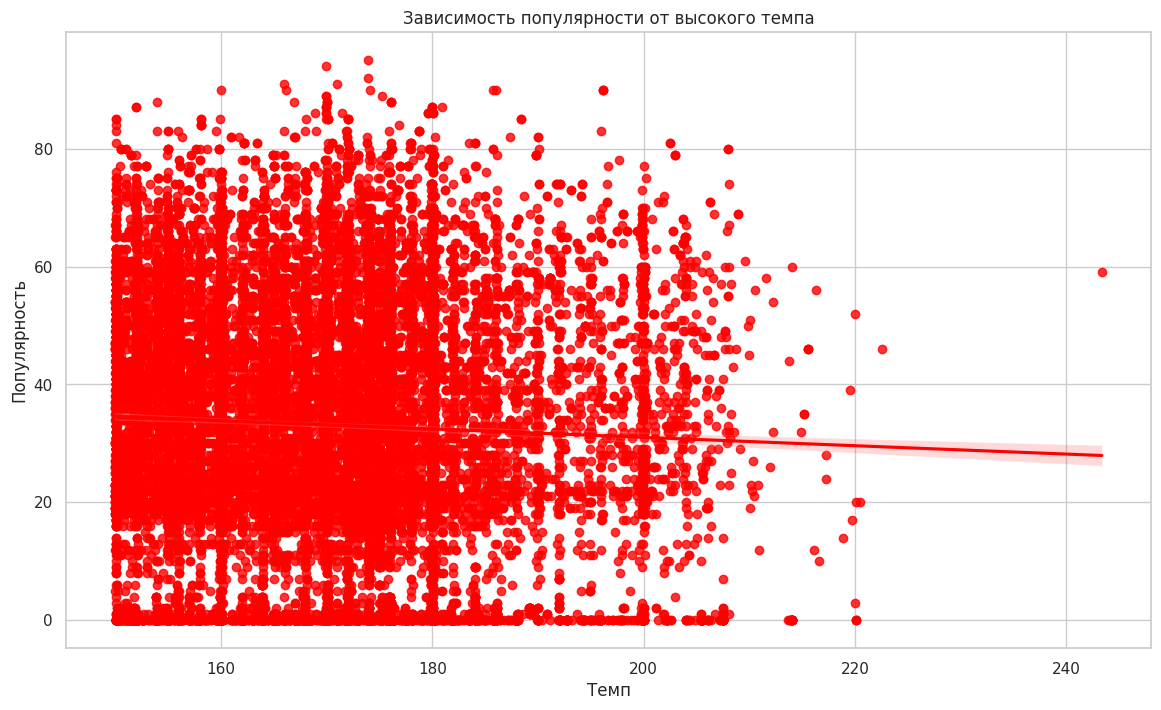

In [15]:
plt.figure(figsize=(14, 8))
sns.regplot(y=df[df['tempo'] >= 150]['popularity'], x=df[df['tempo'] >= 150]['tempo'], color='red')
plt.title('Зависимость популярности от высокого темпа')
plt.ylabel('Популярность')
plt.xlabel('Темп')

plt.show()

Из последних трех графиков видно, что есть такая тенденция с темпом, что чем выше или ниже значения темпа относительно среднего значения темпа, тем менее популярными являются песни.

Так для низкого темпо можно сказать, что чем выше темп, тем популярнее песня, для среднего темпа популярность находится на одном уровне и не изменяется от него, а у высокого темпа также, чем выше его значения, тем ниже популярность песен

In [16]:
num_artists = df['artists'].apply(lambda x: len(x.split(',')) if pd.notnull(x) else 1)

print(num_artists.value_counts())

artists
1    113726
2       260
3        13
Name: count, dtype: int64


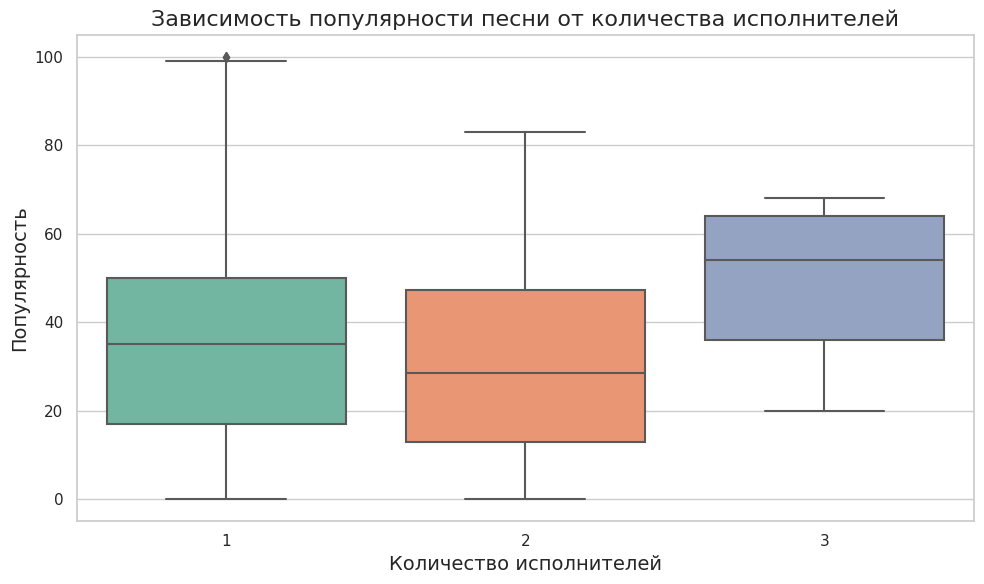

In [17]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=num_artists, y='popularity', data=df, palette="Set2")
plt.title('Зависимость популярности песни от количества исполнителей', fontsize=16)
plt.xlabel('Количество исполнителей', fontsize=14)
plt.ylabel('Популярность', fontsize=14)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

На графике можно увидеть, что количество исполнителей почти не влияет на популярность песни, но при этом песни с 3 исполнителями в среднем более популярны чем с меньшим количеством исполнителей.

Однако количество песен с 2 и 3 исполнителями чрезвычайно мало по отношению к песням с 1 исполнителем, поэтому это такой признак не даст большого прироста к точности модели

In [18]:
print(df['track_genre'].value_counts().unique())

[1000  999]


Из этого вывода количества песен по жанрам, можно сказать, что песни по жанрам распределенны равномерно, имеют количество ~1000, из-за чего не получится выделить косвенно популярные (большие) жанры

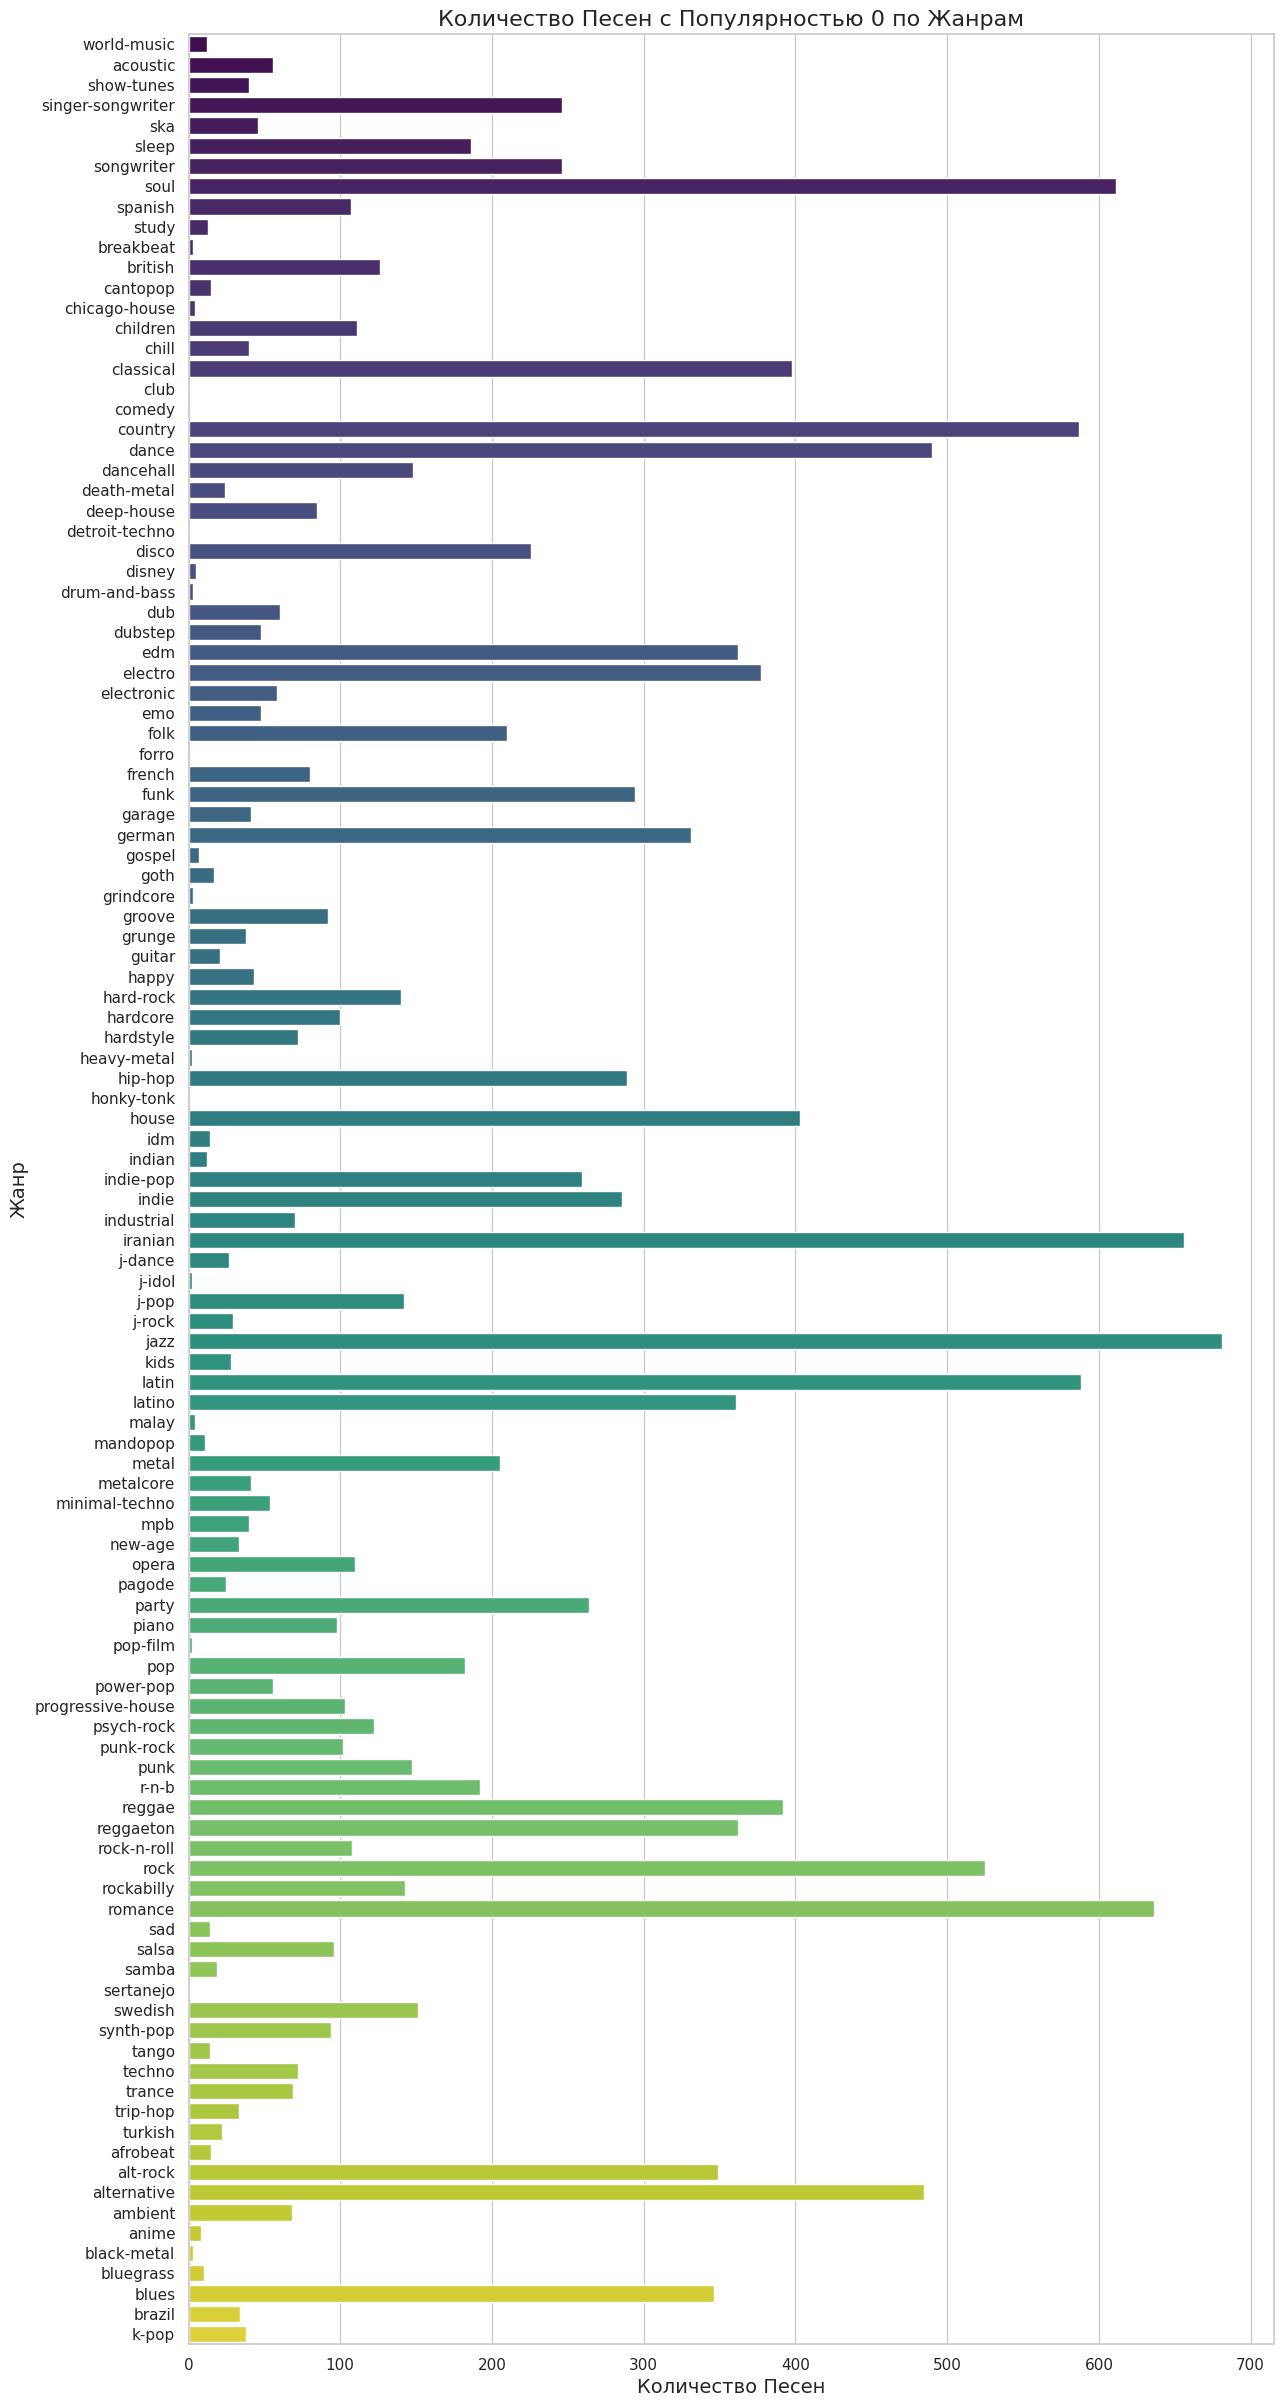

In [19]:
# Распределение нулевой популярности по жанрам
plt.figure(figsize=(14, 30))
sns.countplot(y='track_genre', data=df[df['popularity'] == 0], order=df['track_genre'].value_counts().index, palette='viridis')
plt.title('Количество Песен с Популярностью 0 по Жанрам', fontsize=16)
plt.xlabel('Количество Песен', fontsize=14)
plt.ylabel('Жанр', fontsize=14)
plt.show()

Из этого графика видно, что распределение песен с 0 популярностью у различных жанров также является неравномерным, так есть некоторые жанры, которые вообще не имеют не популярных песен, а  некоторые жанры имеют их гораздо больше по сравнению с другими 

In [20]:
#  track_genre popularity
songs_with_zero_popularity_by_genre =df[df['popularity'] == 0]['track_genre'].value_counts()
songs_by_genre = df['track_genre'].value_counts().sort_index()
all_genres = df['track_genre'].unique()

# Добавляем жанры без песен с популярностью 0 (считаем их как 0)
songs_with_zero_populariy_per_genre = songs_with_zero_popularity_by_genre.reindex(all_genres, fill_value=0).sort_index()

zero_songs_percent_per_genre = songs_with_zero_populariy_per_genre / songs_by_genre

print(zero_songs_percent_per_genre)

track_genre
acoustic       0.056
afrobeat       0.015
alt-rock       0.349
alternative    0.485
ambient        0.068
               ...  
techno         0.072
trance         0.069
trip-hop       0.033
turkish        0.022
world-music    0.012
Name: count, Length: 114, dtype: float64


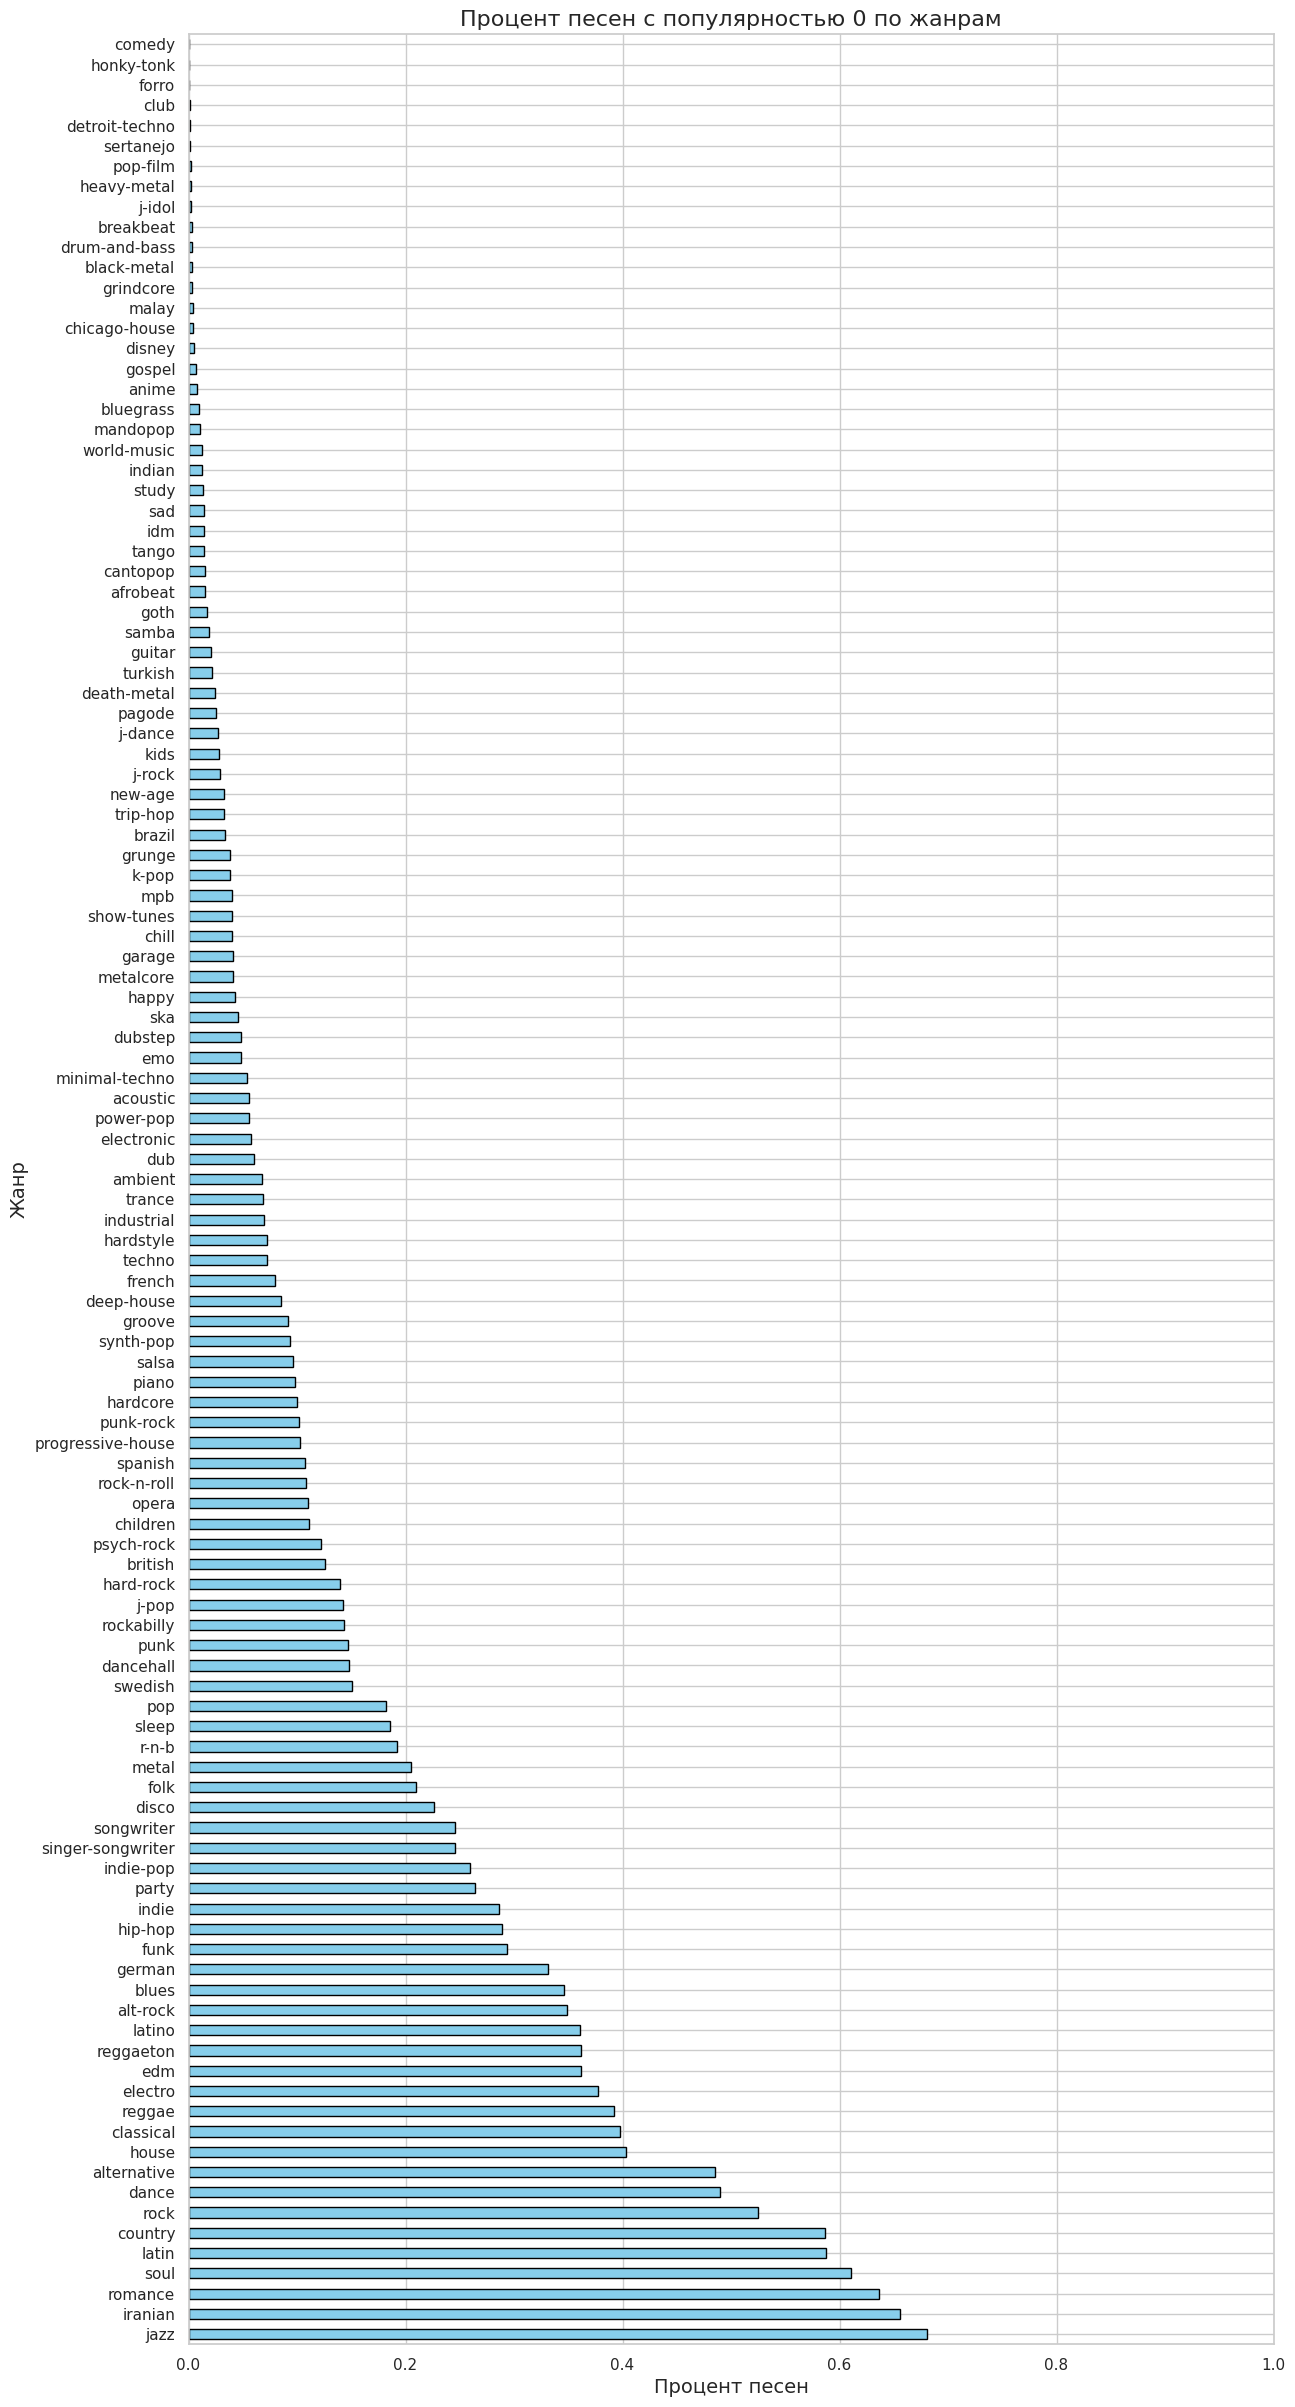

In [21]:
plt.figure(figsize=(14, 30))
zero_songs_percent_per_genre.sort_values(ascending=False).plot(
    kind='barh', color='skyblue', edgecolor='black'
)
plt.title('Процент песен с популярностью 0 по жанрам', fontsize=16)
plt.xlabel('Процент песен', fontsize=14)
plt.ylabel('Жанр', fontsize=14)
plt.xlim([0, 1])
plt.show()

Из этого графика можно увидеть не популярные жанры (процент песен с популярность 0 по жанрам), исходя из этого графика можно сделать новый признак is_unpopular_genre, который будет принимать все жанры у которых процент песен с популярность 0 > 20 

In [22]:
#  track_genre popularity
popular_songs_by_genre = df[df['popularity'] > 50]['track_genre'].value_counts()
all_genres = df['track_genre'].unique()

# Добавляем жанры без песен с популярностью > 50 (считаем их как 0)
popular_songs_by_every_genre = popular_songs_by_genre.reindex(all_genres, fill_value=0).sort_index()

popular_songs_percent_per_genre = popular_songs_by_every_genre / songs_by_genre

print(popular_songs_percent_per_genre)

track_genre
acoustic       0.394
afrobeat       0.025
alt-rock       0.347
alternative    0.312
ambient        0.468
               ...  
techno         0.259
trance         0.209
trip-hop       0.207
turkish        0.047
world-music    0.224
Name: count, Length: 114, dtype: float64


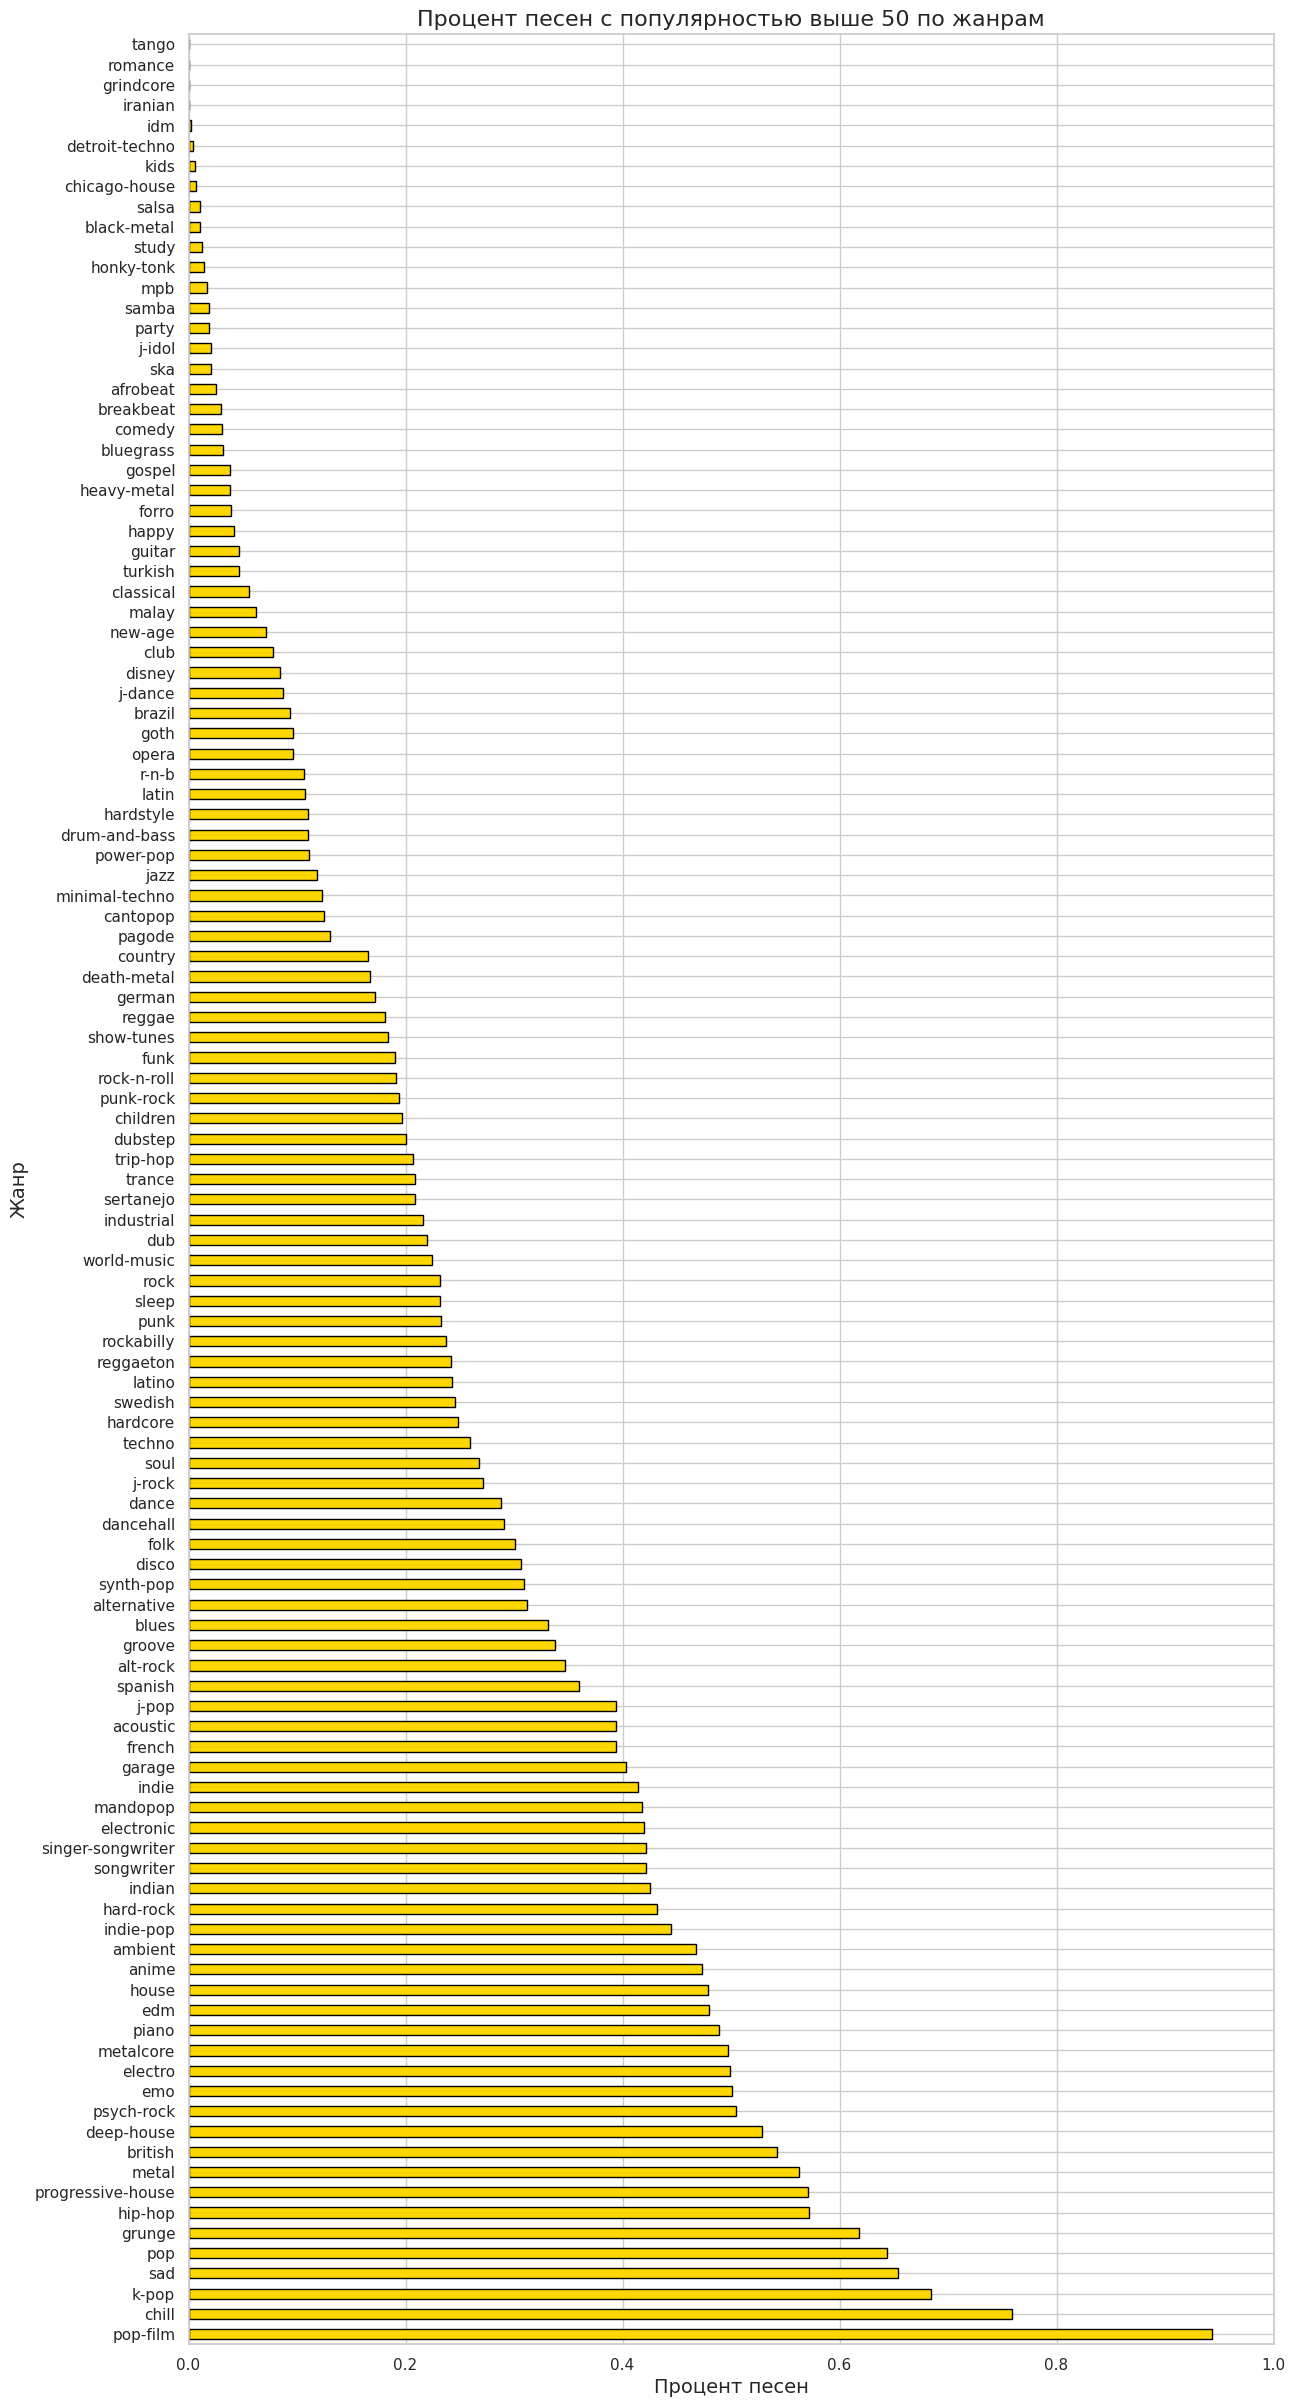

In [23]:
plt.figure(figsize=(14, 30))
popular_songs_percent_per_genre.sort_values(ascending=False).plot(
    kind='barh', color='gold', edgecolor='black'
)
plt.title('Процент песен с популярностью выше 50 по жанрам', fontsize=16)
plt.xlabel('Процент песен', fontsize=14)
plt.ylabel('Жанр', fontsize=14)
plt.xlim([0, 1])
plt.show()

Из этого графика можно увидеть популярные жанры (процент песен с популярность > 50 по жанрам), исходя из этого графика можно сделать новый признак is_popular_genre, который будет принимать все жанры у которых процент песен с популярность > 50 выше 40

Однако, т.к данные предыдущих двух предыдущих графиков были расчитаны с использованием целевого признака popularity было принято не использовать эти данные, чтобы избежать утечки данных.

Стоит учесть то, что можно было бы разметить эти жанры таким образом при получении данных о популярности с внешних источников, а не из используемого датасета

Однако сам признак track_genre все же будет оставлен и закодирован для обучения на нем моделей, т.к модель с возможностью предсказывать нелинейные зависимости сможет самы сделать нужные выводы о популярности на основе получаемых ей закодированных жанров.

In [24]:
# Принимает то, что все песни у которых популярность > 50 являются популярными
is_popular = df['popularity'].apply(lambda x: 1 if x > 50 else 0)

# Проверка распределения классов
is_popular.value_counts()

popularity
0    86229
1    27770
Name: count, dtype: int64

In [25]:
features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
            'instrumentalness', 'liveness', 'valence', 'tempo']

for feature in features:
    print(f'Разброс уникальных значений {feature}')
    print(f'Min: {df[feature].min()}, Max:{df[feature].max()}\n')

Разброс уникальных значений danceability
Min: 0.0, Max:0.985

Разброс уникальных значений energy
Min: 0.0, Max:1.0

Разброс уникальных значений loudness
Min: -49.531, Max:4.532

Разброс уникальных значений speechiness
Min: 0.0, Max:0.965

Разброс уникальных значений acousticness
Min: 0.0, Max:0.996

Разброс уникальных значений instrumentalness
Min: 0.0, Max:1.0

Разброс уникальных значений liveness
Min: 0.0, Max:1.0

Разброс уникальных значений valence
Min: 0.0, Max:0.995

Разброс уникальных значений tempo
Min: 0.0, Max:243.372



Между минимальным и максимальным значениями признаков нет слишком большого разброса данных, это говорит о том, что в данном случае не надо нормализировать данные т.к нет слишком больших и слишком маленьких значений

Однако больший разброс имеют признаки loudness и tempo, однако они не имеет слишком больших значений (-1e4< or > 1e4), чтобы перетянуть на себя слишком большие коэффциенты при обучении

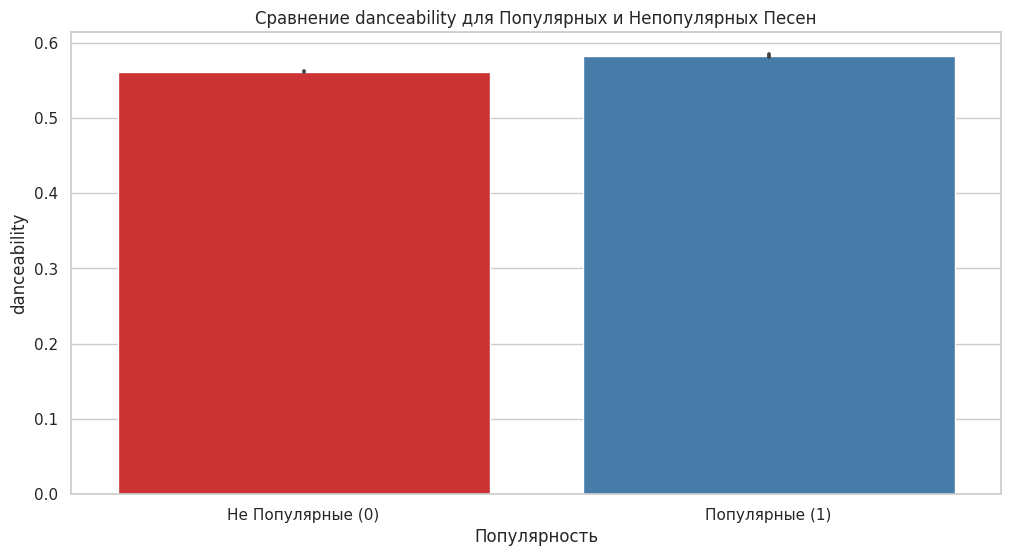

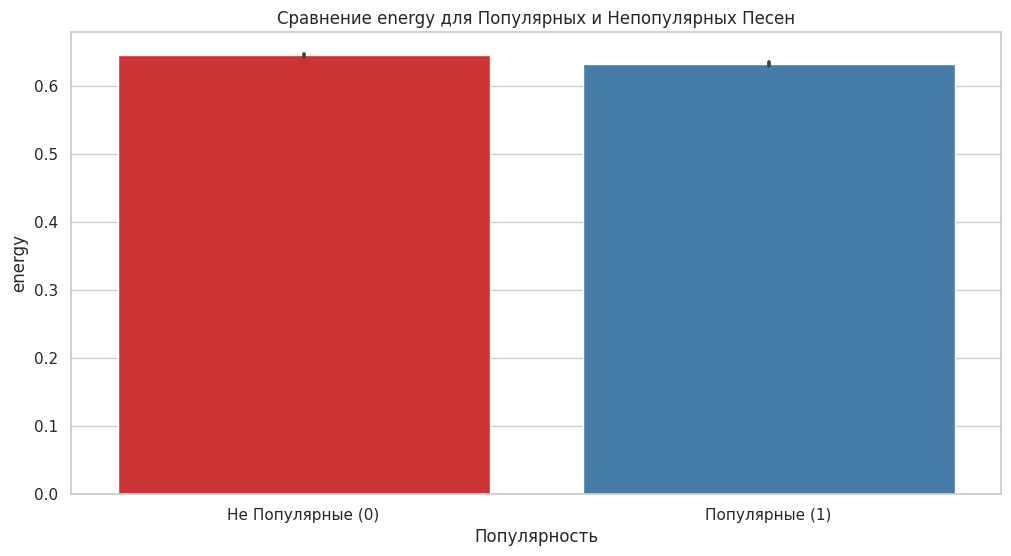

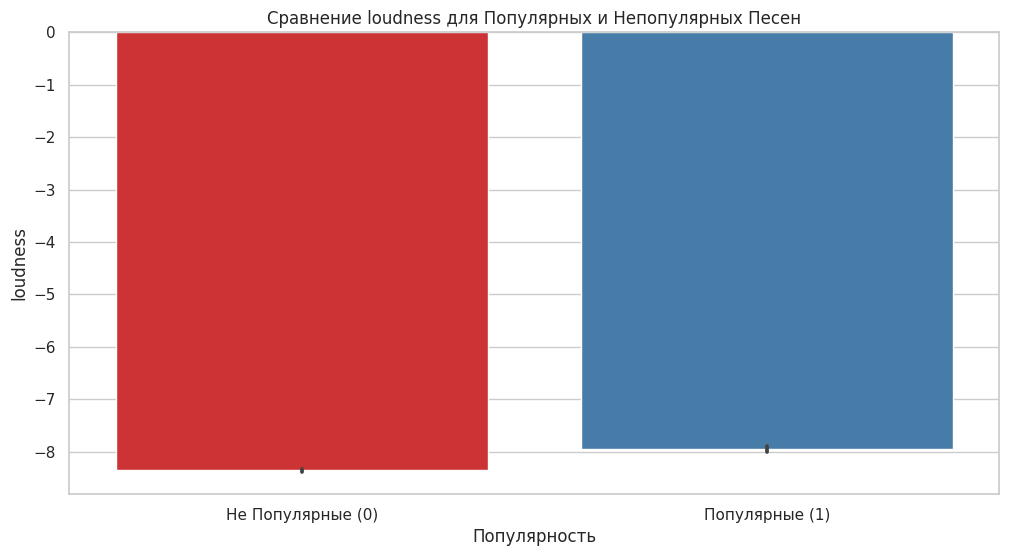

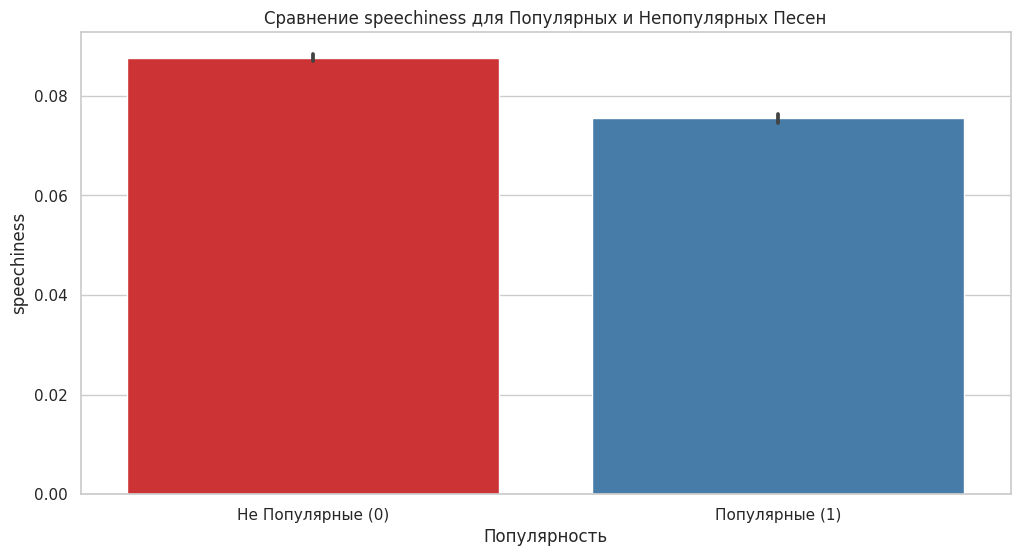

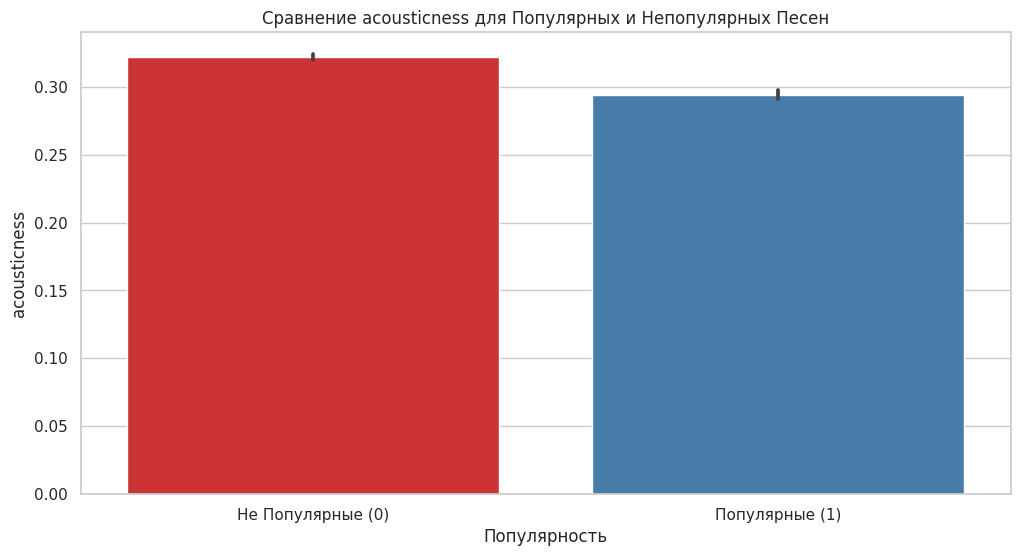

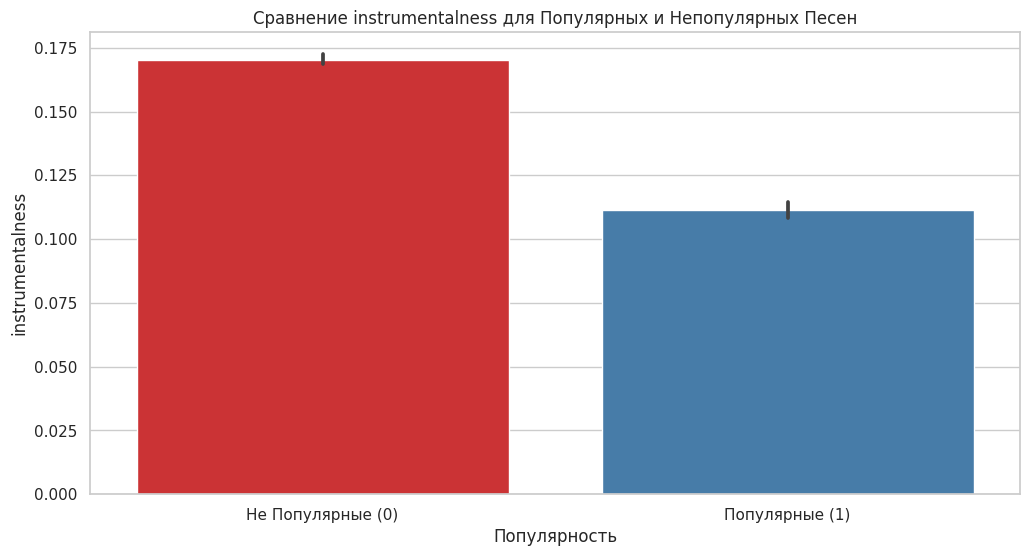

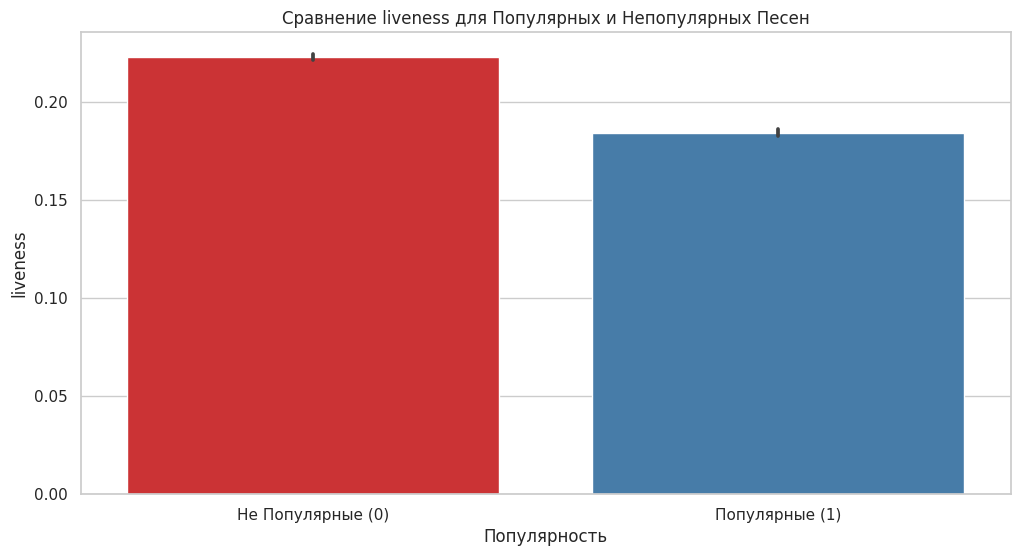

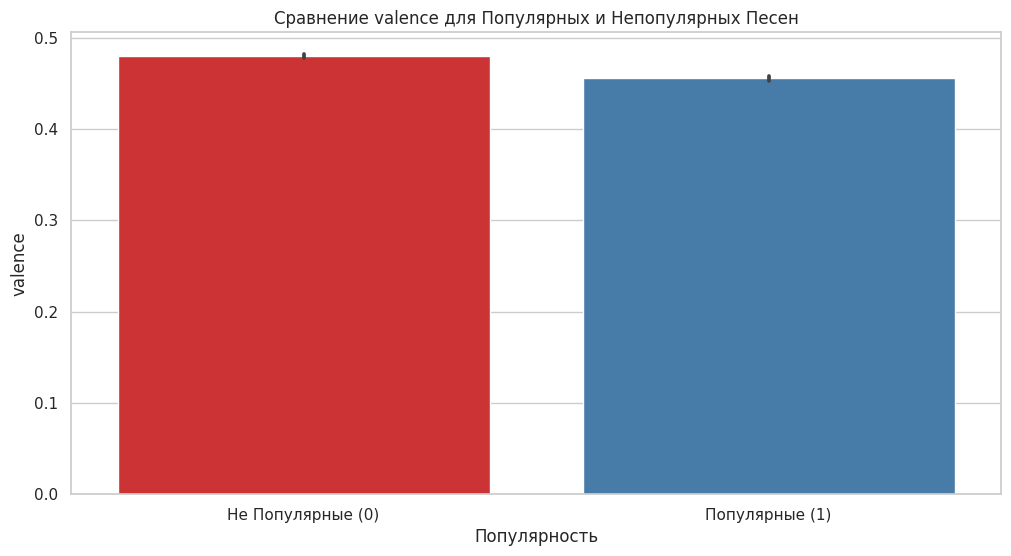

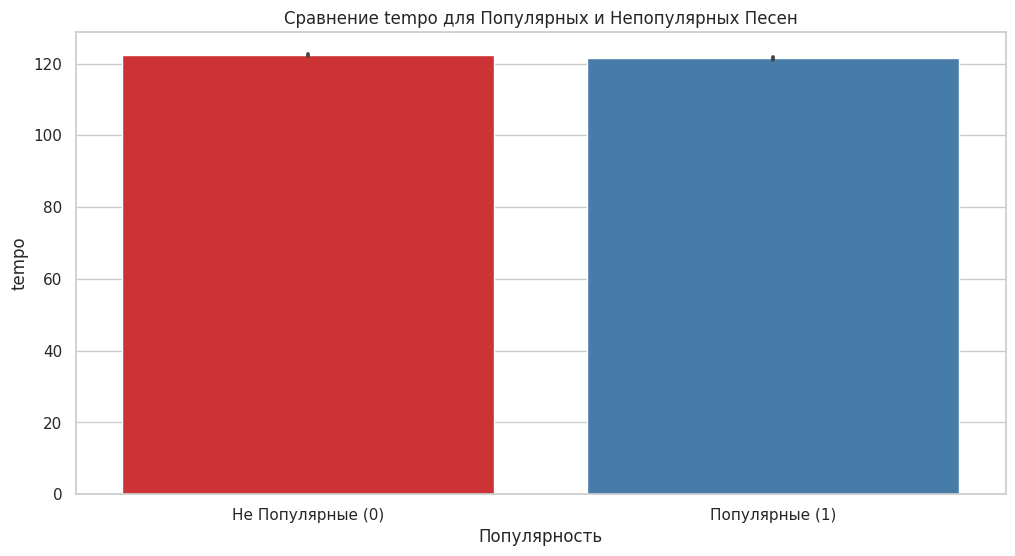

In [26]:
# Пример: сравнение признаков для популярных и непопулярных песен
for feature in features:    
    plt.figure(figsize=(12,6))
    sns.barplot(x=is_popular, y=df[feature], data=df, palette='Set1')
    plt.title(f'Сравнение {feature} для Популярных и Непопулярных Песен')
    plt.xlabel('Популярность')
    plt.xticks([0,1], ['Не Популярные (0)', 'Популярные (1)'])
    plt.show()

Из этого графиков можно сделать вывод, что в общем эти параметры практически не имеют влияния на популярность, т.к в среднем популярные и не популярные песни имеют примерно одинаковое распределение по признакам

Однако стоит отметить такие признаки, как [liveness, instrumentalness, speechiness] могут иметь довольно высокое отрицательно влияние на популярность т.к. из графиков видно, что популярные песни в среднем имеют более низкие показатели по этим  признакам

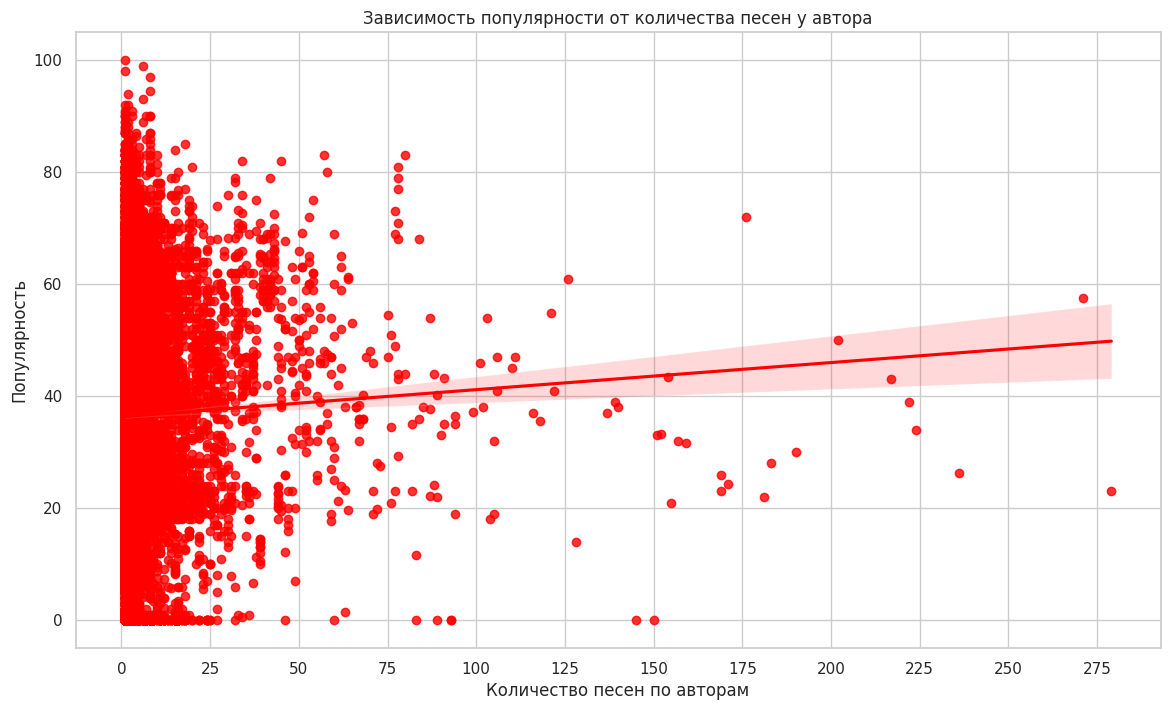

In [27]:
mean_artist_popularity = df.groupby('artists')['popularity'].mean()

plt.figure(figsize=(14, 8))
sns.regplot(y=mean_artist_popularity, x=df['artists'].value_counts(), color='red')
plt.xticks([i for i in range(0, 276, 25)])
plt.title('Зависимость популярности от количества песен у автора')
plt.ylabel('Популярность')
plt.xlabel('Количество песен по авторам')

plt.show()

Из этого графика можно сделать вывод о том, что авторы имеющие большее количество написанных песен с большей вероятностью имеют более высокую популярность. Это может быть связано с тем, что с увеличением количества выпущенных песен автор уже имеет некие навыки создания песен, а также уже имеет свою аудиторию что влияет на популярность остальных его песен

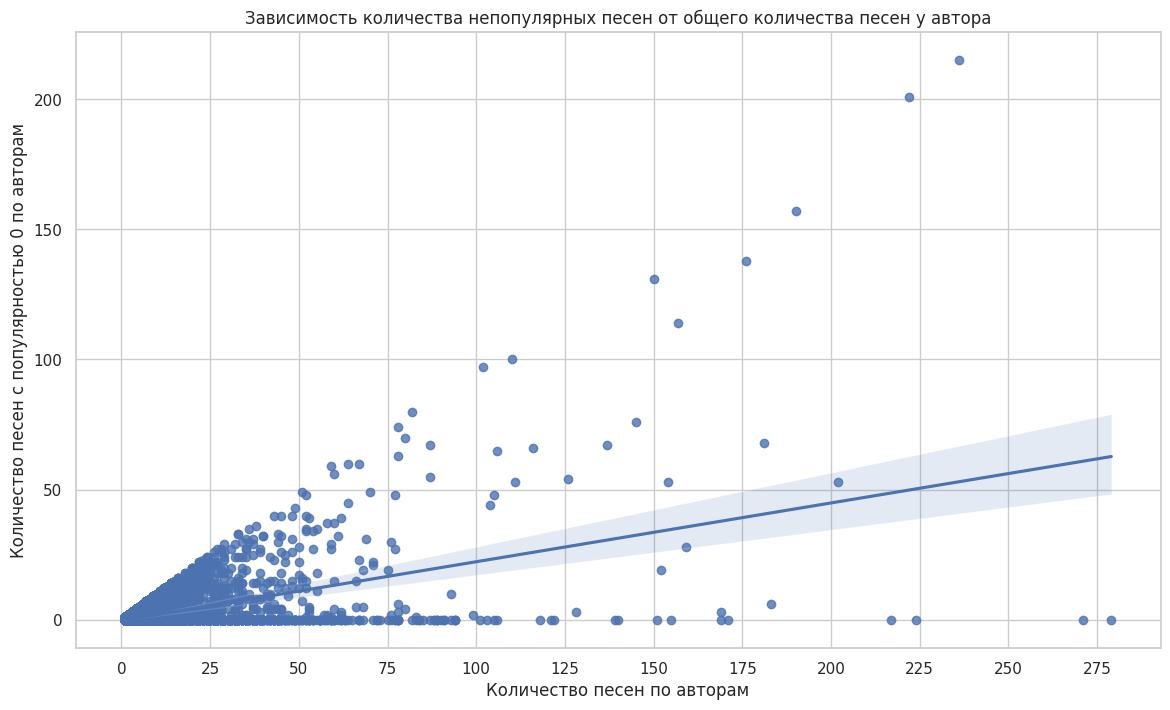

In [28]:
zero_popularity_songs = df[df['popularity'] == 0]
songs_with_zero_popularity = zero_popularity_songs['artists'].value_counts()

# Создаем полный список всех авторов
all_artists = df['artists'].unique()

# Добавляем авторов без песен с популярностью 0 (считаем их как 0)
songs_per_artist = songs_with_zero_popularity.reindex(all_artists, fill_value=0).sort_index()


plt.figure(figsize=(14, 8))
sns.regplot(y=songs_per_artist, x=df['artists'].value_counts().sort_index())
plt.xticks([i for i in range(0, 276, 25)])
plt.title('Зависимость количества непопулярных песен от общего количества песен у автора')
plt.ylabel('Количество песен с популярностью 0 по авторам')
plt.xlabel('Количество песен по авторам')


plt.show()

Этот график подтверждает предыдущий вывод о том, что с большим количеством песен у автора есть больший процент популярных песен, так у авторов, у которых больше 30~ песен скорее всего в разы меньше песен с 0 популярностью

Просмотрим распределения новых комбинированных признаков и то, как они могут повлиять на популярность

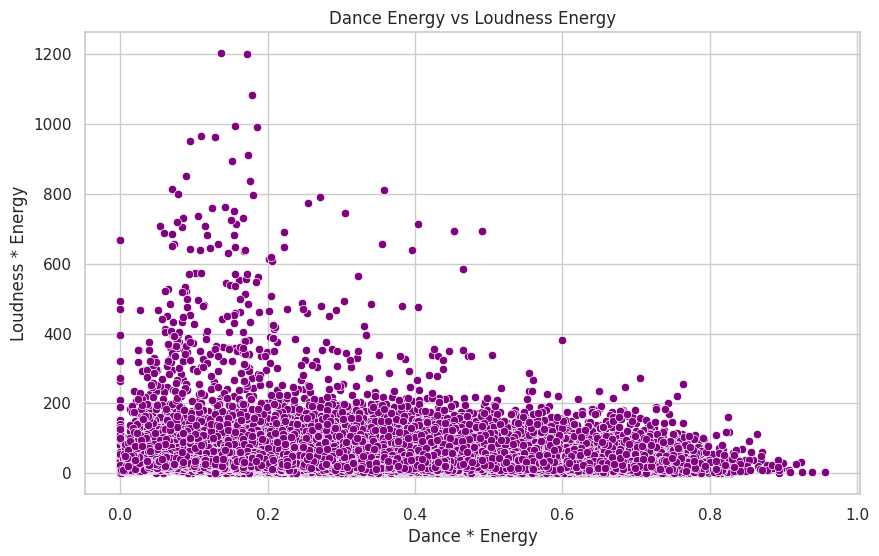

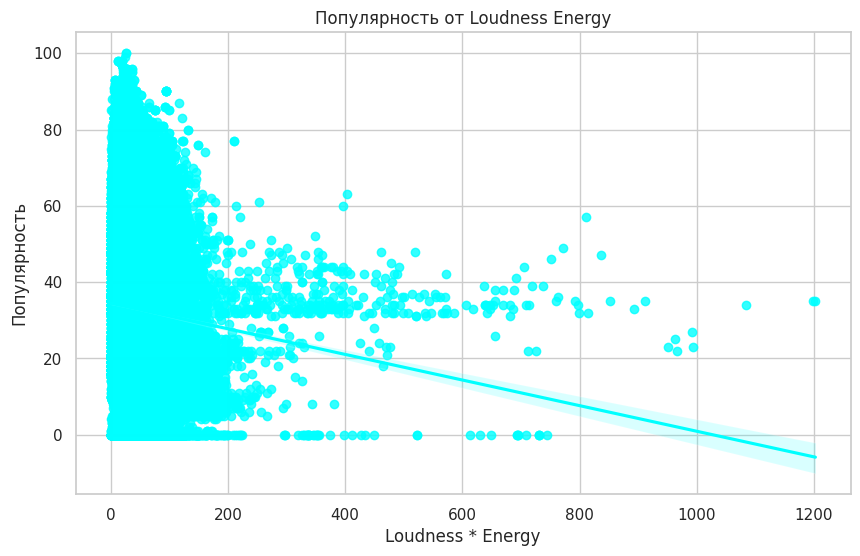

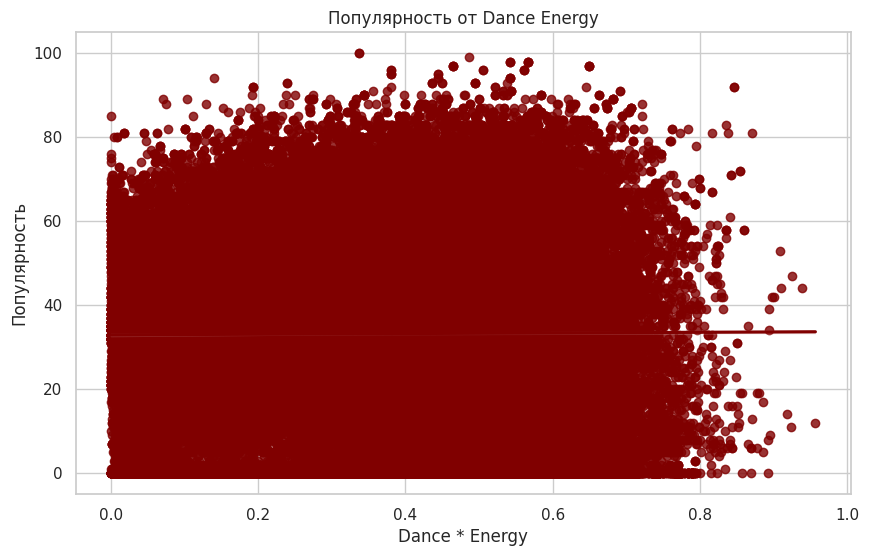

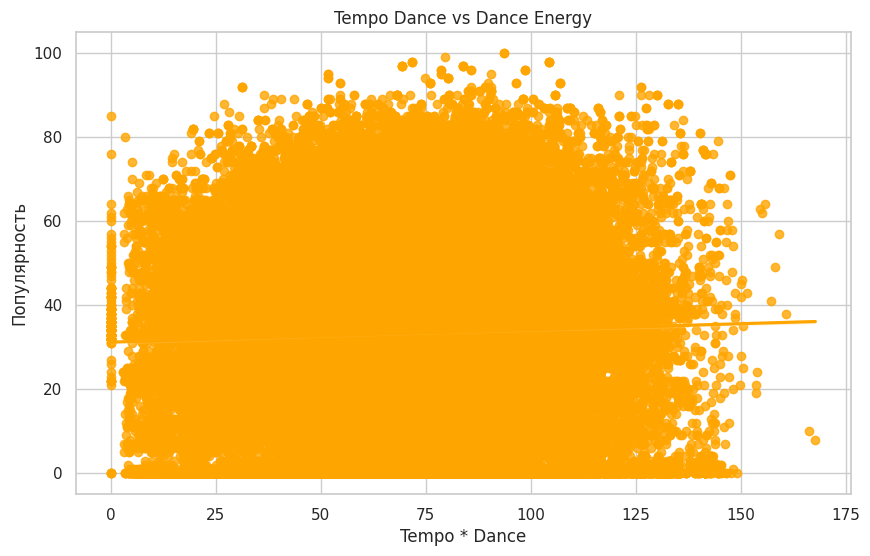

In [29]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['danceability'] * df['energy'], y=pow(df['loudness'], 2) * df['energy'], color='purple')
plt.title('Dance Energy vs Loudness Energy')
plt.xlabel('Dance * Energy')
plt.ylabel('Loudness * Energy')
plt.show()

plt.figure(figsize=(10, 6))
sns.regplot(y=df['popularity'], x=pow(df['loudness'], 2) * df['energy'], color='cyan')
plt.title('Популярность от Loudness Energy')
plt.xlabel('Loudness * Energy')
plt.ylabel('Популярность')
plt.show()

plt.figure(figsize=(10, 6))
sns.regplot(y=df['popularity'], x=df['danceability'] * df['energy'], color='maroon')
plt.title('Популярность от Dance Energy')
plt.xlabel('Dance * Energy')
plt.ylabel('Популярность')
plt.show()

plt.figure(figsize=(10, 6))
sns.regplot(x=df['tempo'] * df['danceability'], y=df['popularity'], color='orange')
plt.title('Tempo Dance vs Dance Energy')
plt.xlabel('Tempo * Dance')
plt.ylabel('Популярность')
plt.show()

Из этих графиков видно, что на популярность довольно сильно влияет комбинированный признак Loudness Energy, немного влияет Tempo Dance и не влияет Energy Dance

Из этого можно сделать вывод, что людям не сильно нравятся громкие энергичные песни, и нравятся танцевальные с высоким темпом

In [30]:
df.head()

artists  popularity  duration_ms  explicit  danceability  \
0             Gen Hoshino          73       230666     False         0.676   
1            Ben Woodward          55       149610     False         0.420   
2  Ingrid Michaelson;ZAYN          57       210826     False         0.438   
3            Kina Grannis          71       201933     False         0.266   
4        Chord Overstreet          82       198853     False         0.618   

   energy  key  loudness  mode  speechiness  acousticness  instrumentalness  \
0  0.4610    1    -6.746     0       0.1430        0.0322          0.000001   
1  0.1660    1   -17.235     1       0.0763        0.9240          0.000006   
2  0.3590    0    -9.734     1       0.0557        0.2100          0.000000   
3  0.0596    0   -18.515     1       0.0363        0.9050          0.000071   
4  0.4430    2    -9.681     1       0.0526        0.4690          0.000000   

   liveness  valence    tempo  time_signature track_genre  
0    0.3580    0.715   87.917               4    acoustic  
1    0.1010    0.267   77.489               4    acoustic  
2    0.1170    0.120   76.332               4    acoustic  
3    0.1320    0.143  181.740               3    acoustic  
4    0.0829    0.167  119.949               4    acoustic

## Создание новых признаков

In [31]:
# Изменяем мс на минуты в длительности
df['duration_min'] = df['duration_ms'] / 60000
df = df.drop(columns=['duration_ms'])

artist_song_counts = df['artists'].value_counts()


# Добавляем признак о том, имеет ли автор много песен
df['hardworker_author'] = df['artists'].map(lambda artist: artist_song_counts[artist])

# Добавляем разделение темпа
df['tempo_group'] = pd.cut(df['tempo'], bins=[-100, 100, 150, 300], labels=['slow', 'medium', 'fast'])


# Добавляем комбинированные признаки
df['loudness_energy'] = pow(df['loudness'], 2) * df['energy']
df['tempo_dance'] = df['tempo'] * df['danceability']

df['loudness_energy_per_minute'] = df['loudness_energy'] / df['duration_min']

Создаем 6 новых признаков: переводим миллисекунды в минуты, добавляем признак о том, сколько песен выпустил автор, разбиваем темп на группы. Также добавляем комбинированные признаки на основе полученной информации из графиков: зависимость громкости от энергии, зависимость темпа от танцевальности, а также "громкая энергия" в минуту 

In [32]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df['tempo_group'] = label_encoder.fit_transform(df['tempo_group'])
df['track_genre_encoded'] = label_encoder.fit_transform(df['track_genre'])
df['artists_encoded'] = label_encoder.fit_transform(df['artists'])
df['explicit'] = df['explicit'].map({True: 1, False: 0})

Преобразовываем категориальные признаки в числовые при помощи Label Encoder'а

In [33]:
# Проверяем типы данных у признаков
df.dtypes

artists                        object
popularity                      int64
explicit                        int64
danceability                  float64
energy                        float64
key                             int64
loudness                      float64
mode                            int64
speechiness                   float64
acousticness                  float64
instrumentalness              float64
liveness                      float64
valence                       float64
tempo                         float64
time_signature                  int64
track_genre                    object
duration_min                  float64
hardworker_author               int64
tempo_group                     int64
loudness_energy               float64
tempo_dance                   float64
loudness_energy_per_minute    float64
track_genre_encoded             int64
artists_encoded                 int64
dtype: object

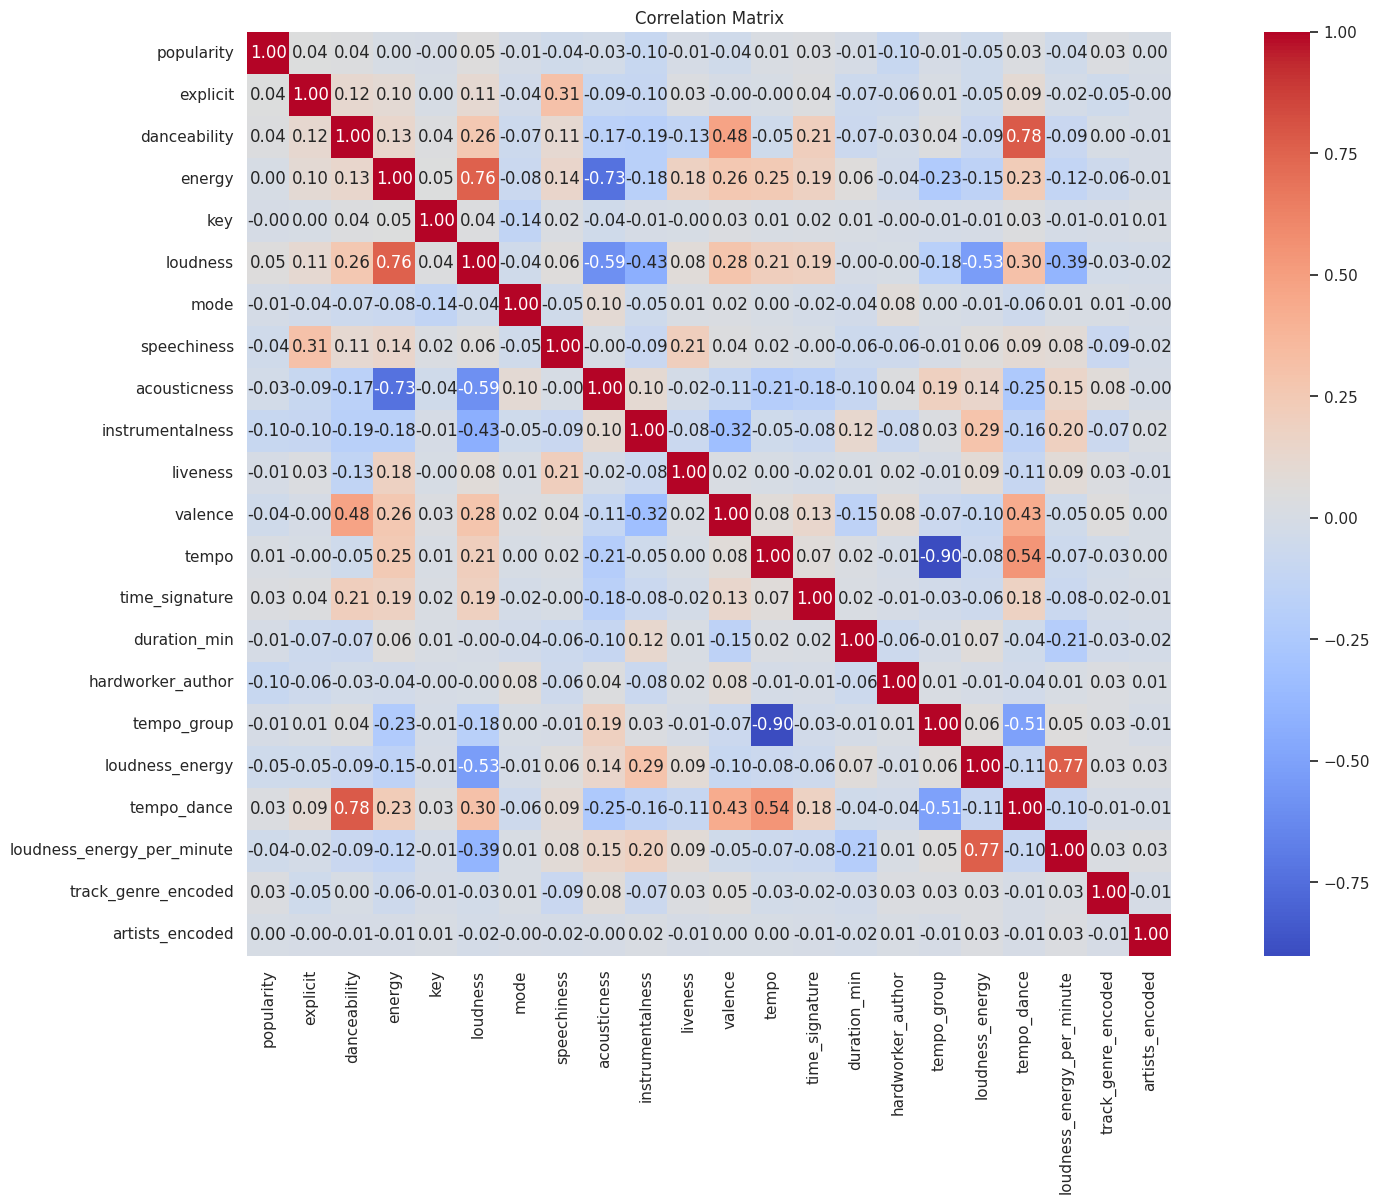

In [34]:
# Расчет матрицы корреляции
df_corr = df.drop(columns=['track_genre', 'artists'])
correlation_matrix = df_corr.corr()

# Визуализация матрицы корреляции
plt.figure(figsize=(24, 12))
sns.heatmap(
    correlation_matrix,
    annot=True,          # Отображение значений корреляции
    fmt=".2f",           # Формат чисел
    cmap="coolwarm",     # Цветовая палитра
    cbar=True,           # Добавление цветовой шкалы
    square=True          # Квадратные ячейки
)
plt.title("Correlation Matrix")
plt.show()

Из корреляционной матрицы видно, что признаки практически не имеют никакой корреляции с целевым признаком, только признаки instrumentalness и hardworker_author имеют небольшое (-0.1) отрицаетльное влияние на целевой признак

Это может быть связано с тем, что популярность зависит от сложного набора различных признаков, что может говорить о явной нелинейной зависимости, с которой лучше всего справляются различные бэггинги, бустинги и нейронные сети

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X = df.drop(columns=['popularity', 'track_genre', 'artists'])

# Удаляем целевой признак
y = df['popularity']

# Разделяем на тренировочные и тестовые данные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание модели LinearRegression
model_linear_regression = LinearRegression()
# Обучение модели
model_linear_regression.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred_linear_regression = model_linear_regression.predict(X_test)

# Оценка модели
mae_linear_regression = mean_absolute_error(y_test, y_pred_linear_regression)
mse_linear_regression = mean_squared_error(y_test, y_pred_linear_regression)
rmse_linear_regression = mean_squared_error(y_test, y_pred_linear_regression, squared=False)  # Корень из MSE
r2_linear_regression = r2_score(y_test, y_pred_linear_regression)

# Выводим результаты
print(f"MAE: {mae_linear_regression}")
print(f"MSE: {mse_linear_regression}")
print(f"RMSE: {rmse_linear_regression}")
print(f"R2: {r2_linear_regression}")

MAE: 18.239122512414777
MSE: 479.5608901995463
RMSE: 21.898878742975548
R2: 0.03331774644593244


Как и предполагалось линейная регрессия очень плохо справляется с этой задачей, т.к. у данных у этой задаче присутствует нелинейная зависимость, которую линейная регрессия не может учесть

In [36]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

model_random_forest = RandomForestRegressor(n_estimators=50, criterion='friedman_mse',  random_state=42)

# Обучение модели
model_random_forest.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred_random_forest = model_random_forest.predict(X_test)

# Оценка модели
mae_random_forest = mean_absolute_error(y_test, y_pred_random_forest)
mse_random_forest = mean_squared_error(y_test, y_pred_random_forest)
rmse_random_forest = mean_squared_error(y_test, y_pred_random_forest, squared=False)  # Корень из MSE
r2_random_forest = r2_score(y_test, y_pred_random_forest)

# Выводим результаты
print(f"MAE: {mae_random_forest}")
print(f"MSE: {mse_random_forest}")
print(f"RMSE: {rmse_random_forest}")
print(f"R2: {r2_random_forest}")

MAE: 10.104645122490775
MSE: 214.786451017955
RMSE: 14.655594529665283
R2: 0.5670409019039861


В качестве модели бэггинга был выбран случайный лес, так как является одним из лучших в такого рода задачах. Как и предполагалось случайный лес очень хорошо справился с этой задачей и в итоге имеет в среднем MAE = 10, MSE = 220, RMSE = 15, R2 = 0.56

In [37]:
# Создание модели GradientBoostingRegressor
model_boosting = GradientBoostingRegressor(n_estimators=50, max_depth=5, criterion='friedman_mse',  random_state=42)

# Обучение модели
model_boosting.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred_boosting = model_boosting.predict(X_test)

# Оценка модели
mae_boosting = mean_absolute_error(y_test, y_pred_boosting)
mse_boosting = mean_squared_error(y_test, y_pred_boosting)
rmse_boosting = mean_squared_error(y_test, y_pred_boosting, squared=False)  # Корень из MSE
r2_boosting = r2_score(y_test, y_pred_boosting)

# Выводим результаты
print(f"MAE: {mae_boosting}")
print(f"MSE: {mse_boosting}")
print(f"RMSE: {rmse_boosting}")
print(f"R2: {r2_boosting}")

MAE: 15.422241504756652
MSE: 371.32906180204645
RMSE: 19.269900409759426
R2: 0.2514877221877767


Из бустингов был выбран GradientBoostingRegressor, который с каждой новой итерацией обучения дообучает модель путем учитывания ошибок предыдущих моделей. Градиентный бустинг также довольно хорошо показал себя в этой задаче, так при n_estimators = 100 эта модель может достичь показателей близких к показателям случайного леса, однако с таким количеством n_estimators модель обучается в разы больше, чем случайный лес, который может получить такие результаты с n_estimators = 25

In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Определение модели
input_size = X_train.shape[1]

model = Sequential([
    Dense(256, activation='relu', input_shape=(input_size,)),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)  # Выходной слой для регрессии
])

# Компиляция модели
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-3), loss='mse')

# Преобразование данных в формат NumPy
X_train_np = X_train.values
y_train_np = y_train.values
X_test_np = X_test.values
y_test_np = y_test.values

# Обучение модели
history = model.fit(
    X_train_np, y_train_np,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_np, y_test_np),
    verbose=1
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


I0000 00:00:1734203639.122989     208 service.cc:145] XLA service 0x7989c0004fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734203639.123046     208 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  96/2850 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1863832.8750 

I0000 00:00:1734203640.433817     208 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2850/2850 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 115565.5547 - val_loss: 526.3893
Epoch 2/50
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 527.0055 - val_loss: 521.8917
Epoch 3/50
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 521.9050 - val_loss: 605.4213
Epoch 4/50
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 517.7081 - val_loss: 500.3469
Epoch 5/50
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 511.8690 - val_loss: 488.4283
Epoch 6/50
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 502.3362 - val_loss: 487.0269
Epoch 7/50
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 496.7741 - val_loss: 485.4379
Epoch 8/50
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 502.2811 - val_loss: 499.6544
Epoch 9/50
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 500.2383 - val_loss: 496.2938
Epoch 10/50
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 498.5042 - val_loss: 496.0862
Epoch 11/50
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 500.4359 - val_loss: 498

In [39]:
# Оценка модели
y_pred = model.predict(X_test_np).squeeze()
mae_net = mean_absolute_error(y_test_np, y_pred)
mse_net = mean_squared_error(y_test_np, y_pred)
rmse_net = mse_net ** 0.5
r2_net = r2_score(y_test_np, y_pred)

print(f"MAE: {mae_net:.4f}")
print(f"MSE: {mse_net:.4f}")
print(f"RMSE: {rmse_net:.4f}")
print(f"R2: {r2_net:.4f}")

713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MAE: 18.8868
MSE: 496.1312
RMSE: 22.2740
R2: -0.0001


В качестве нейронной сети использовался обычный перспетрон, состоящий из 7 слоев, со средним количеством нейронов. При этом перспетрон получает довольно плохие результаты, несмотря на свои возможности выносить нелинейные признаки, при этом стоит отметить, что при значительном увеличении нейронов качество модели не слишком сильно улучшается, так например я при добавлении еще 4 слоев с 2048 нейронов улучшил MAE примерно на 2 единицы и получил значения ~16

In [40]:
print(f"Линейная регрессия: MAE: {mae_linear_regression:.2f}, MSE: {mse_linear_regression:.2f}, RMSE: {rmse_linear_regression:.2f}, R^2: {r2_linear_regression:.2f}")
print(f"Случайный лес: MAE: {mae_random_forest:.2f}, MSE: {mse_random_forest:.2f}, RMSE: {rmse_random_forest:.2f}, R^2: {r2_random_forest:.2f}")
print(f"Бустинг: MAE: {mae_boosting:.2f}, MSE: {mse_boosting:.2f}, RMSE: {rmse_boosting:.2f}, R^2: {r2_boosting:.2f}")
print(f"Персептрон: MAE: {mae_net:.2f}, MSE: {mse_net:.2f}, RMSE: {rmse_net:.2f}, R^2: {r2_net:.2f}")

Линейная регрессия: MAE: 18.24, MSE: 479.56, RMSE: 21.90, R^2: 0.03
Случайный лес: MAE: 10.10, MSE: 214.79, RMSE: 14.66, R^2: 0.57
Бустинг: MAE: 15.42, MSE: 371.33, RMSE: 19.27, R^2: 0.25
Персептрон: MAE: 18.89, MSE: 496.13, RMSE: 22.27, R^2: -0.00


По итогам можно смело сказать, что лучше всего с задачей справился случайный лес за счет своей структуры, еще с этой задачей может справиться также хорошо градиентный бустинг, однако время обучения у него будет незначительно, но выше чем у случайного леса

Хуже всего себя показали персептрон и линейная регрессия, причины такого плохого результата у линейной регрессии ясны - невозможность учитывать нелинейные зависимости однако по сравнению с линейной регрессией персептрон можно считать еще худшей альтернативой, т.к для такого большого датасета полносвязная модель будет довольно долго обучаться, при этом выдавая не очень хороший результат на выходе

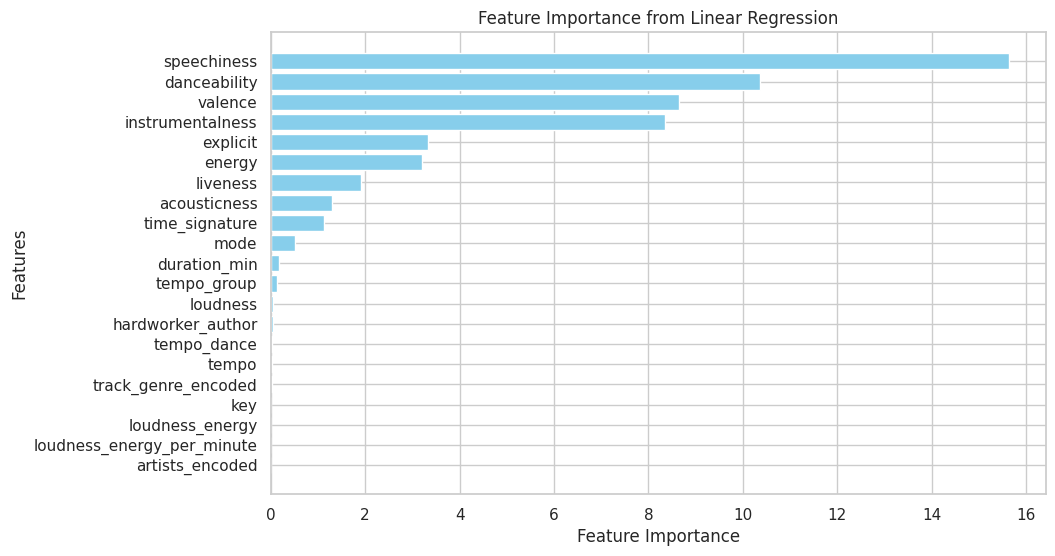

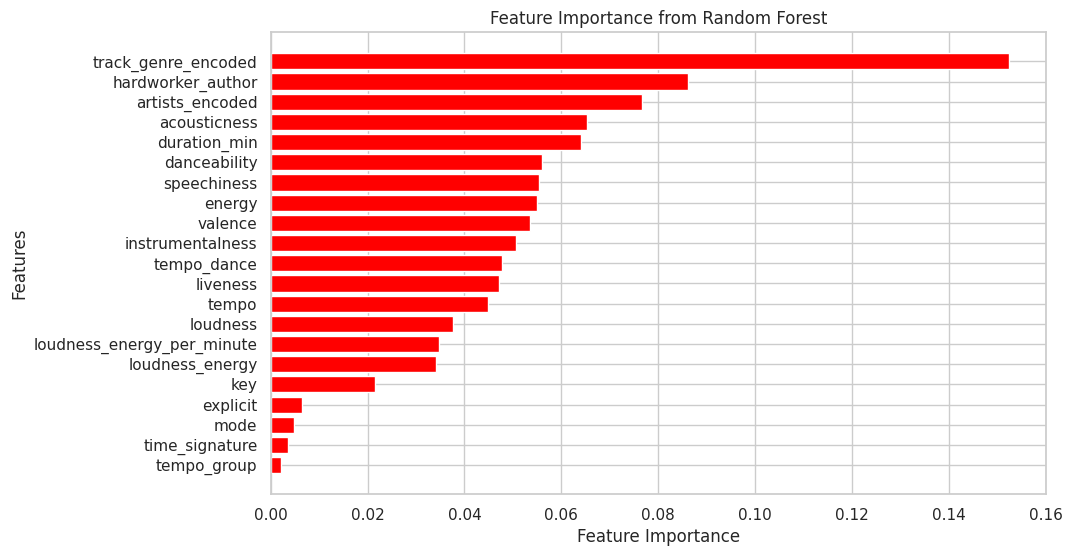

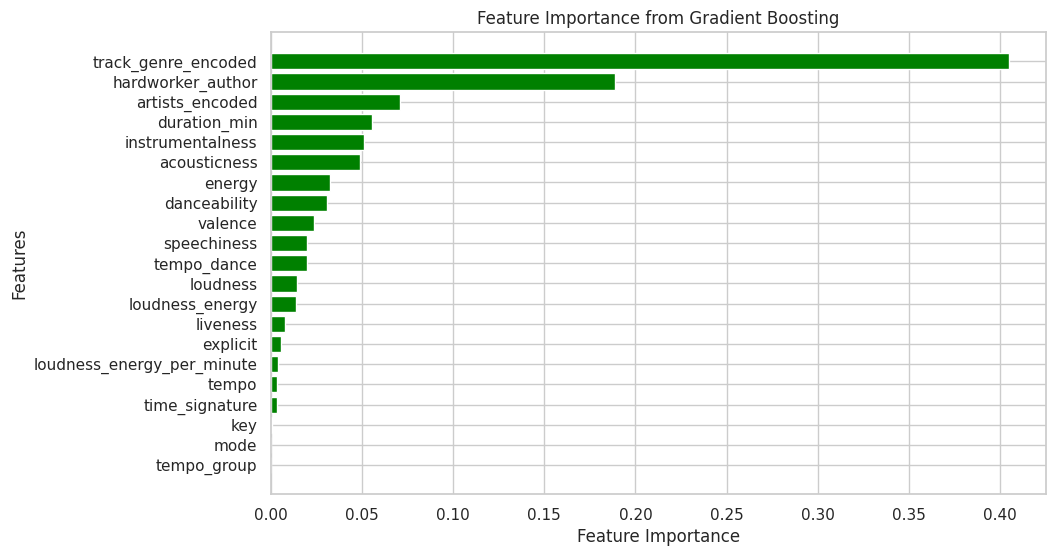

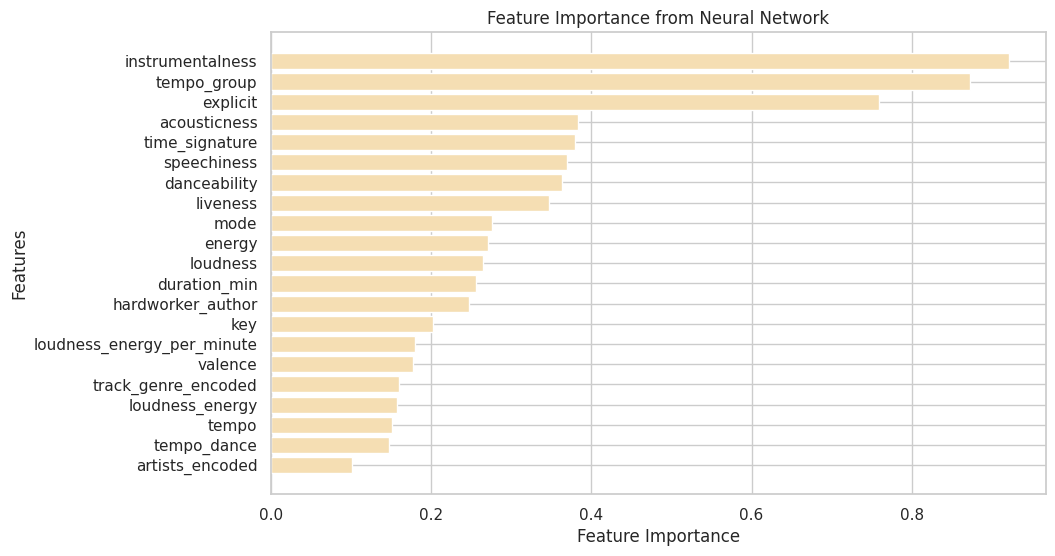

In [41]:
# Извлечение коэффициентов
coefficients = model_linear_regression.coef_

# Создание DataFrame
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(coefficients)
}).sort_values(by='Importance', ascending=False)

# Визуализация
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from Linear Regression')
plt.gca().invert_yaxis()
plt.show()


# ---

# Получение важности признаков
feature_importances = model_random_forest.feature_importances_

# Создание DataFrame для удобного отображения
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,  # Названия признаков
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='red')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()  # Самые важные признаки сверху
plt.show()

# ---

# Извлечение важности
feature_importances = model_boosting.feature_importances_

# Создание DataFrame
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Визуализация
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='green')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from Gradient Boosting')
plt.gca().invert_yaxis()
plt.show()


# ---


# Извлечение весов первого слоя
weights = model.layers[0].get_weights()[0]  # Первый слой, веса
feature_importances = [np.mean(np.abs(weight)) for weight in weights]

# Создание DataFrame
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Визуализация
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='wheat')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from Neural Network')
plt.gca().invert_yaxis()
plt.show()

Исходя из этих графиков можно сказать, что случайный лес и градиентный бустинг обращали свое внимание на одни признаки, а линейная регрессия и персептрон

Так случайный лес и градиентный бустинг обращали свое внимание на авторов песни, количество песен выпущенных автором, а также на жанр песни

Линейная регрессия обращала внимание на словестность, танцевальность, valence, инструментальность

Персептрон же обращали свое внимание на признаки: инструментальность, группа темпа, брань, акустичность

In [42]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Функция для вычисления метрик
def compute_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

# Линейная регрессия
print("Linear Regression:")
for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    model_linear_regression.fit(X.iloc[train_idx], y.iloc[train_idx])
    y_pred = model_linear_regression.predict(X.iloc[val_idx])
    rmse, mae, r2 = compute_metrics(y.iloc[val_idx], y_pred)
    print(f"Fold {fold}: RMSE = {rmse:.4f}, MAE = {mae:.4f}, R² = {r2:.4f}")

# Случайный лес
print("\nRandom Forest:")
for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    model_random_forest.fit(X.iloc[train_idx], y.iloc[train_idx])
    y_pred = model_random_forest.predict(X.iloc[val_idx])
    rmse, mae, r2 = compute_metrics(y.iloc[val_idx], y_pred)
    print(f"Fold {fold}: RMSE = {rmse:.4f}, MAE = {mae:.4f}, R² = {r2:.4f}")

# Градиентный бустинг
print("\nGradient Boosting:")
for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    model_boosting.fit(X.iloc[train_idx], y.iloc[train_idx])
    y_pred = model_boosting.predict(X.iloc[val_idx])
    rmse, mae, r2 = compute_metrics(y.iloc[val_idx], y_pred)
    print(f"Fold {fold}: RMSE = {rmse:.4f}, MAE = {mae:.4f}, R² = {r2:.4f}")


Linear Regression:
Fold 1: RMSE = 21.8989, MAE = 18.2391, R² = 0.0333
Fold 2: RMSE = 21.9429, MAE = 18.2424, R² = 0.0345
Fold 3: RMSE = 21.9418, MAE = 18.2798, R² = 0.0345
Fold 4: RMSE = 21.8224, MAE = 18.1852, R² = 0.0383
Fold 5: RMSE = 21.9518, MAE = 18.2377, R² = 0.0339

Random Forest:
Fold 1: RMSE = 14.6815, MAE = 10.0743, R² = 0.5655
Fold 2: RMSE = 14.7218, MAE = 10.1318, R² = 0.5654
Fold 3: RMSE = 14.8403, MAE = 10.2527, R² = 0.5583
Fold 4: RMSE = 14.7265, MAE = 10.1614, R² = 0.5621
Fold 5: RMSE = 14.6968, MAE = 10.1690, R² = 0.5670

Gradient Boosting:
Fold 1: RMSE = 19.2699, MAE = 15.4222, R² = 0.2515
Fold 2: RMSE = 19.3286, MAE = 15.4327, R² = 0.2508
Fold 3: RMSE = 19.5162, MAE = 15.6326, R² = 0.2362
Fold 4: RMSE = 19.2495, MAE = 15.4167, R² = 0.2517
Fold 5: RMSE = 19.3729, MAE = 15.4752, R² = 0.2476


Модель случайного леса показала лучший результат с минимальными ошибками и высокой точностью 
Градиентный бустинг оказался средним, а линейная регрессия — наименее эффективной

In [43]:
# Массивы для хранения метрик
mae_scores = []
mse_scores = []
rmse_scores = []
r2_scores = []

k=5

# Кросс-валидация
fold = 1
for train_index, val_index in kf.split(X):
    print(f"Training fold {fold}/{k}...")
    
    # Разделение данных на обучающие и валидационные
    X_train_fold, X_val_fold = X.values[train_index], X.values[val_index]
    y_train_fold, y_val_fold = y.values[train_index], y.values[val_index]
    
    # Определение модели
    model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train_fold.shape[1],)),
        Dense(512, activation='relu'),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)
    ])
    
    # Компиляция модели
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse')
    
    # Обучение модели
    model.fit(
        X_train_fold, y_train_fold,
        epochs=50,
        batch_size=128,
        verbose=0  # Отключение вывода для каждого фолда
    )
    
    # Предсказания на валидационной выборке
    y_val_pred = model.predict(X_val_fold).squeeze()
    
    # Вычисление метрик
    mae = mean_absolute_error(y_val_fold, y_val_pred)
    mse = mean_squared_error(y_val_fold, y_val_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_val_fold, y_val_pred)
    
    # Сохранение метрик
    mae_scores.append(mae)
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    
    print(f"Fold {fold} - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")
    fold += 1

Training fold 1/5...


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Fold 1 - MAE: 17.9628, MSE: 469.2633, RMSE: 21.6625, R2: 0.0541
Training fold 2/5...


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Fold 2 - MAE: 18.0176, MSE: 473.6150, RMSE: 21.7627, R2: 0.0503
Training fold 3/5...


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Fold 3 - MAE: 18.9648, MSE: 523.8920, RMSE: 22.8887, R2: -0.0506
Training fold 4/5...


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Fold 4 - MAE: 18.1459, MSE: 475.0970, RMSE: 21.7967, R2: 0.0406
Training fold 5/5...


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Fold 5 - MAE: 18.0523, MSE: 473.7207, RMSE: 21.7651, R2: 0.0503


In [44]:
# Средние значения метрик по всем фолдам
print("\nCross-Validation Results:")
print(f"Mean MAE: {np.mean(mae_scores):.4f}")
print(f"Mean MSE: {np.mean(mse_scores):.4f}")
print(f"Mean RMSE: {np.mean(rmse_scores):.4f}")
print(f"Mean R2: {np.mean(r2_scores):.4f}")


Cross-Validation Results:
Mean MAE: 18.2287
Mean MSE: 483.1176
Mean RMSE: 21.9751
Mean R2: 0.0289


Модель персептрона показала низкую точность, с R2 = 0.0635, что указывает на слабую способность объяснять вариацию данных

Результаты моделей показали, что успех музыки определяется множеством случайных и хаотичных факторов, которые не поддаются выявлению с помощью существующих алгоритмов машинного обучения. Это подчёркивает реальность, где популярность трека часто обусловлена непредсказуемыми и внеаналитическими обстоятельствами

Также на результаты моделей повлияло то, что распределение популярности является неравномерным, где песен с околонулевой популярность очень много, а песен с большой популярностью >80 в разы меньше

Для этой задачи лучше всего себя показал случайный лес с показателями 

Случайный лес: MAE: 10.10, MSE: 214.79, RMSE: 14.66, R^2: 0.57